In [2]:
text ='2023/11/08, 2023/11/15, 2023/11/22'
target_date_list = text.replace('/','-').split(', ')
target_date_list

['2023-11-08', '2023-11-15', '2023-11-22']

In [74]:
from PIL import Image, ImageDraw, ImageFont
im= Image.new("L", (280, 100),color=(0))
im.putalpha(0)
im2= Image.new("L", (260, 50),color=(50))
im2.putalpha(128)


draw = ImageDraw.Draw(im)
font = ImageFont.truetype('font/LightNovelPOPv2.otf',19)
syuzai_name_text = 'あああああああああ'

# 画像を表示

im.paste(im2, (25,48))
draw.multiline_text(
    (150, 50),
    f'{syuzai_name_text}',
    font=font,
    fill='white',
    align='center',
    spacing=0,
    anchor='ma'
)
im.save('syuzai_image.png', quality=95)




In [75]:
im = Image.open('syuzai_image.png')
im3 = Image.open('icon.png')
im.paste(im3, (-15,-14))
im.save('syuzai_image.png', quality=95)

In [24]:
'''5月20日(土)は0の付く日です。
過去3回分の0の付く日のデータを取得し、分析しました。
結果は以下の通りです。
・0の付く日の平均回転数は、0.0回転です。
・0の付く日の平均差枚数は、0.0枚です。
'''

'5月20日(土)は0の付く日です。\n過去3回分の0の付く日のデータを取得し、分析しました。\n結果は以下の通りです。\n・0の付く日の平均回転数は、0.0回転です。\n・0の付く日の平均差枚数は、0.0枚です。\n'

In [34]:
str(target_day_list).replace("'",'"')

'["2023-05-16", "2023-05-06", "2023-04-26"]'

In [2]:
from flask import Flask, render_template, request
from datetime import date, timedelta,datetime
import pandas as pd
import requests
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor

In [92]:


user_data = {}
user_data['tenpo-name'] = 'マルハン新宿東宝ビル店'
user_data['n-times'] = '3'
user_data['target-date'] = '2023-05-17'
print(user_data)
print(user_data['tenpo-name'],user_data['n-times'],user_data['target-date'])
target_day_list = []
number = 0
today = date.today()
target_number:int = str(user_data['target-date'][-1])
for i in range(int(user_data['n-times'])):
    while True:
        #print(str(date.today() - timedelta(days=number))[-1])
        if target_number == str(today - timedelta(days=number))[-1]:
            target_day = today - timedelta(days=number)
            print('取得日',target_day)
            target_day_str = target_day.strftime('%Y-%m-%d')
            target_day_list.append(target_day_str)
            number += 1
            break
        else: 
            pass
        number += 1
target_day_list.reverse()
concat_df_list = []
urls = []
for serch_date in target_day_list:
    search_url = url = f"https://ana-slo.com/{serch_date}-{user_data['tenpo-name']}-data/"
    urls.append(search_url)

with ThreadPoolExecutor(3) as executor:
    results = list(executor.map(requests.get, urls))
print(results)

for search_response,target_day in zip(results, target_day_list):
    soup = BeautifulSoup(search_response.text, "lxml")
    elem = soup.select('#all_data_block')
    dfs = pd.read_html(str(elem))
    for df in dfs:
        if '機種名' in list(df.columns):
            tmp_df = df
            tmp_df['日付'] = target_day
            #tmp_df['機種名'] = tmp_df['機種名'].map(removal_text)
            break
    concat_df_list.append(df)

concat_df = pd.concat(concat_df_list,axis=0)
for column_name in ['合成確率','BB確率','RB確率','台番号','ART確率']:
    try:
        concat_df = concat_df.drop([column_name],axis=1)
    except:
        pass

concat_df

{'tenpo-name': 'マルハン新宿東宝ビル店', 'n-times': '3', 'target-date': '2023-05-17'}
マルハン新宿東宝ビル店 3 2023-05-17
取得日 2023-05-17
取得日 2023-05-07
取得日 2023-04-27
[<Response [200]>, <Response [200]>, <Response [200]>]


,機種名,G数,差枚,BB,RB,日付
0,アイムジャグラーEX-TP,8571,-600,25,35,2023-04-27
1,アイムジャグラーEX-TP,7359,1800,34,21,2023-04-27
2,アイムジャグラーEX-TP,5261,-900,16,14,2023-04-27
3,アイムジャグラーEX-TP,8510,-500,29,27,2023-04-27
4,アイムジャグラーEX-TP,6577,-200,26,17,2023-04-27
...,...,...,...,...,...,...
521,マッピー,2958,100,11,4,2023-05-17
522,マッピー,3118,-900,11,6,2023-05-17
523,沖ドキ!DUO-30,6312,-2800,28,21,2023-05-17
524,沖ドキ!DUO-30,5278,-500,30,22,2023-05-17


In [99]:
kisyubetu_master_df = concat_df.groupby(['機種名']).sum()
kisyubetu_master_df['総台数'] = concat_df.groupby(['機種名']).size()
kisyubetu_master_df = kisyubetu_master_df.reset_index(drop=False).reset_index().rename(columns={'index': '機種順位','ゲーム数': 'G数'})
kisyubetu_master_df['機種順位'] = kisyubetu_master_df['機種順位'] + 1
kisyubetu_master_df[['機種順位','機種名','総台数','G数','差枚']]
kisyubetu_win_daissuu_list = []
kisyubetu_master_df_list = []
for kisyu_name in kisyubetu_master_df['機種名']:
    kisyu_df = concat_df.query('機種名 == @kisyu_name')
    kisyubetu_master_df_list.append(kisyu_df)
    kisyu_win_daisuu = len(kisyu_df[kisyu_df['差枚'] > 0])
    kisyubetu_win_daissuu_list.append(kisyu_win_daisuu)
kisyubetu_master_df['勝率'] = kisyubetu_win_daissuu_list
kisyubetu_master_df['勝率'] = kisyubetu_master_df['勝率'].astype(str)
kisyubetu_master_df['総台数'] = kisyubetu_master_df['総台数'].astype(int)
kisyubetu_master_df['平均G数'] = kisyubetu_master_df['G数'] / kisyubetu_master_df['総台数']
kisyubetu_master_df['平均G数'] = kisyubetu_master_df['平均G数'].astype(int)
kisyubetu_master_df = kisyubetu_master_df[kisyubetu_master_df['総台数'] >= 2 ]
kisyubetu_master_df['差枚'] = kisyubetu_master_df['差枚'].astype(int)
kisyubetu_master_df['平均差枚'] = kisyubetu_master_df['差枚'] / kisyubetu_master_df['総台数']
kisyubetu_master_df['平均差枚'] = kisyubetu_master_df['平均差枚'].astype(int) 
kisyubetu_master_df['総台数'] = kisyubetu_master_df['総台数'].astype(str) 
kisyubetu_master_df['勝率'] = kisyubetu_master_df['勝率'] + '/' + kisyubetu_master_df['総台数']
kisyubetu_master_df['勝率'] = kisyubetu_master_df['勝率'].map(lambda x : '(' + x + '台) ' + str(round(int(x.split('/')[0])/int(x.split('/')[1])*100,1))  + '%')
kisyubetu_master_df = kisyubetu_master_df[['機種順位','機種名','勝率','平均G数','平均差枚','差枚','G数','総台数']]
kisyubetu_master_df = kisyubetu_master_df.sort_values('平均差枚',ascending=False)
kisyubetu_master_df['機種順位'] = list(range(1,len(kisyubetu_master_df)+1))
kisyubetu_master_df['機種平均出率'] =(((kisyubetu_master_df['G数'] * 3) + kisyubetu_master_df['差枚']) / (kisyubetu_master_df['G数'] * 3) )*100
kisyubetu_master_df['機種平均出率'] = kisyubetu_master_df['機種平均出率'].map(lambda x : round(x,1))
kisyubetu_master_df['機種平均出率'] = kisyubetu_master_df['機種平均出率'].astype(str) + '%'
kisyubetu_master_df = kisyubetu_master_df.rename(columns={'G数': '合計G数','差枚': '合計差枚'})
kisyubetu_master_df

,機種順位,機種名,勝率,平均G数,平均差枚,合計差枚,合計G数,総台数,機種平均出率
19,1,バジリスク絆2,(25/27台) 92.6%,5509,2651,71600,148758,27,116.0%
35,2,戦姫絶唱シンフォギア 勇気の歌,(9/13台) 69.2%,6110,1646,21400,79430,13,109.0%
26,3,モンスターハンター:ワールドTM 黄金狩猟,(4/6台) 66.7%,6046,1400,8400,36279,6,107.7%
36,4,押忍!番長ZERO,(32/46台) 69.6%,4865,1319,60700,223797,46,109.0%
12,5,ディスクアップ2,(6/9台) 66.7%,5931,1133,10200,53384,9,106.4%
13,6,ニューゲッターマウス,(3/3台) 100.0%,5821,1066,3200,17464,3,106.1%
30,7,北斗の拳 宿命,(2/2台) 100.0%,4502,1050,2100,9005,2,107.8%
29,8,劇場版 魔法少女まどか☆マギカ[前編]始まりの物語/[後編]永遠の物語,(3/6台) 50.0%,3757,1016,6100,22542,6,109.0%
6,9,アバサー,(4/6台) 66.7%,6199,750,4500,37194,6,104.0%
44,10,甲鉄城のカバネリ,(29/51台) 56.9%,5237,731,37300,267113,51,104.7%


In [68]:
for search_response,target_day in zip(results, target_day_list):
    soup = BeautifulSoup(search_response.text, "lxml")
    elem = soup.select('#all_data_block')
    dfs = pd.read_html(str(elem))
    for df in dfs:
        if '機種名' in list(df.columns):
            tmp_df = df
            tmp_df['日付'] = target_day
            #tmp_df['機種名'] = tmp_df['機種名'].map(removal_text)
            break
    concat_df_list.append(df)

concat_df = pd.concat(concat_df_list,axis=0)
for column_name in ['合成確率','BB確率','RB確率','台番号','ART確率']:
    try:
        concat_df = concat_df.drop([column_name],axis=1)
    except:
        pass
concat_df = concat_df.drop(['機種名'],axis=1)
groupby_samai_game_mean_df = concat_df .groupby('日付').mean()
groupby_samai_game_mean_df.reset_index(inplace=True)
groupby_samai_game_mean_df['差枚'] = groupby_samai_game_mean_df['差枚'].astype(int)
groupby_samai_game_mean_df['G数'] = groupby_samai_game_mean_df['G数'].astype(int)
groupby_samai_game_mean_df['差枚'] = groupby_samai_game_mean_df['差枚'].astype(str)
groupby_samai_game_mean_df['G数'] = groupby_samai_game_mean_df['G数'].astype(str)
groupby_samai_game_mean_df['BB'] = groupby_samai_game_mean_df['BB'].astype(int)
groupby_samai_game_mean_df['RB'] = groupby_samai_game_mean_df['RB'].astype(int)
samai_list:list[int] = groupby_samai_game_mean_df['差枚'].tolist()
gamesuu_list:list[int] = groupby_samai_game_mean_df['G数'].tolist()
gamesuu_list

['1807', '1794', '1832', '1416']

In [69]:


record = [samai_list,gamesuu_list]
ave_tenpo_df = pd.DataFrame(record, columns=target_day_list,index=['平均差枚','平均G数'])
ave_tenpo_df[0:1]  =  ave_tenpo_df[0:1]  + '枚'
ave_tenpo_df[1:2]  =  ave_tenpo_df[1:2]  + 'G'
ave_tenpo_df


,2023-04-16,2023-04-26,2023-05-06,2023-05-16
平均差枚,-58枚,77枚,-48枚,64枚
平均G数,1807G,1794G,1832G,1416G


In [64]:
ave_tenpo_df

,2023-04-26,2023-05-06,2023-05-16
平均差枚,49枚,58枚,100枚
平均G数,4951G,5579G,5239G


In [56]:
ave_tenpo_df.

['4951', '5579', '5239']

In [8]:
touhou_df = df[df['店舗名'] == 'マルハン新宿東宝ビル店']
touhou_df[['日付', 'Nの日', '都道府県', '店舗名', '機種名', '台番号', '末尾', 'G数', '差枚',
       'BB', 'RB', 'BB確率', 'RB確率', '合成確率']]

,日付,Nの日,都道府県,店舗名,機種名,台番号,末尾,G数,差枚,BB,RB,BB確率,RB確率,合成確率
93054,2022/12/09 00:00:00,9,東京都,マルハン新宿東宝ビル店,アイムジャグラーEX-TP,917,7,2992.0,-800,8.0,7.0,1/374.0,1/427.4,1/199.5
93055,2022/12/09 00:00:00,9,東京都,マルハン新宿東宝ビル店,アイムジャグラーEX-TP,918,8,6365.0,100,23.0,21.0,1/276.7,1/303.1,1/144.7
93056,2022/12/09 00:00:00,9,東京都,マルハン新宿東宝ビル店,アイムジャグラーEX-TP,919,9,8552.0,-1300,25.0,30.0,1/342.1,1/285.1,1/155.5
93057,2022/12/09 00:00:00,9,東京都,マルハン新宿東宝ビル店,アイムジャグラーEX-TP,920,0,5093.0,1800,26.0,13.0,1/195.9,1/391.8,1/130.6
93058,2022/12/09 00:00:00,9,東京都,マルハン新宿東宝ビル店,アイムジャグラーEX-TP,921,1,6930.0,1600,31.0,23.0,1/223.5,1/301.3,1/128.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93541,2022/12/09 00:00:00,9,東京都,マルハン新宿東宝ビル店,ゼーガペイン2,995,5,0.0,0,0.0,0.0,1/0.0,1/0.0,1/0.0
93542,2022/12/09 00:00:00,9,東京都,マルハン新宿東宝ビル店,閃乱カグラ BURST UP,996,6,0.0,0,0.0,0.0,1/0.0,1/0.0,1/0.0
93543,2022/12/09 00:00:00,9,東京都,マルハン新宿東宝ビル店,ハイスクールD×D2 ハーレム王に俺はなる,997,7,0.0,0,0.0,0.0,1/0.0,1/0.0,1/0.0
93544,2022/12/09 00:00:00,9,東京都,マルハン新宿東宝ビル店,ドリフターズ,998,8,0.0,0,0.0,0.0,1/0.0,1/0.0,1/0.0


In [ ]:
touhou_df = df[df['店舗名'] == 'マルハン新宿東宝ビル店']
touhou_df[['日付', 'Nの日', '都道府県', '店舗名', '機種名', '台番号', '末尾', 'G数', '差枚',
       'BB', 'RB', 'BB確率', 'RB確率', '合成確率']]


In [1]:
import pandas as pd



In [3]:
tenpo_url_df:pd.DataFrame = pd.read_csv('csv/tenpo_url_flask_web_site.csv')
group_name_list:list[str] ='''123,BBステーション,DAS,Dステーション,MGM,PIA,やすだ,ウエスタン,エスパス,\
    エンジェル,オゼック,オリエンタルパサージュ,オーパス・ワン,カレイド,キコーナ,\
    キューデンアネックス,グランパ,コンサートホール,ゴードン,ジャラン,\
    ジャンジャンマールゴット,デルパラ,ドキわくランド,ニラク,パラッツォ,\
    パーラースーパーセブン,パーラーフィオーレ,ヒノマル,ヒロキ,ビックディッパー,\
    ピーアーク,フルハウス,プレゴ,ベガスベガス,マルハン,ミカド,ミリオン,ガイア,\
    メッセ,国際センター,UNO,楽園,オーシャン,金時'''.split(',')
others_extract_tokyo_tenpo_url_df = extract_tokyo_tenpo_url_df = tenpo_url_df[tenpo_url_df['都道府県'] == '東京都']
extract_tokyo_tenpo_url_df = extract_tokyo_tenpo_url_df.sort_values('店舗名')
extract_tokyo_tenpo_url_df

group_name_count_dict:dict[str] = {}
web_group_name_list:list[str] = []
for group_name in group_name_list:
    extract_groupname_df = extract_tokyo_tenpo_url_df[extract_tokyo_tenpo_url_df['店舗名'].str.contains(group_name)]
    #display(extract_groupname_df)
    group_name_count_dict[group_name] = len(extract_groupname_df)
    #break
    #print(group_name)
    tmp_list = []
    #print(group_name)
    for tenpo_name in extract_groupname_df['店舗名']:
        tmp_list.append(tenpo_name)
        target = extract_tokyo_tenpo_url_df.index[(extract_tokyo_tenpo_url_df['店舗名'] == tenpo_name)]
    web_group_name_list.append(tmp_list)


sorted_group_name_count_dict = sorted(group_name_count_dict.items(), key = lambda fruit : fruit[1])
print(type(sorted_group_name_count_dict))
# <class 'list'>
sorted_group_name_count_dict.reverse()
sorted_group_name_count_dict = dict(sorted_group_name_count_dict)
sorted_group_name_count_dict

group_name_count_dict:dict[str] = {}
web_group_name_list:list[str] = []
for group_name in sorted_group_name_count_dict:
    extract_groupname_df = extract_tokyo_tenpo_url_df[extract_tokyo_tenpo_url_df['店舗名'].str.contains(group_name)]
    #display(extract_groupname_df)
    group_name_count_dict[group_name] = len(extract_groupname_df)
    #break
    #print(group_name)
    tmp_list = []
    #print(group_name)
    for tenpo_name in extract_groupname_df['店舗名']:
        tmp_list.append(tenpo_name)
        target = extract_tokyo_tenpo_url_df.index[(extract_tokyo_tenpo_url_df['店舗名'] == tenpo_name)]
    web_group_name_list.append(tmp_list)
    

others_extract_tokyo_tenpo_url_df = extract_tokyo_tenpo_url_df 
for group_name in sorted_group_name_count_dict:
    extract_groupname_df = extract_tokyo_tenpo_url_df[extract_tokyo_tenpo_url_df['店舗名'].str.contains(group_name)]
    for tenpo_name in extract_groupname_df['店舗名']:
        target = extract_tokyo_tenpo_url_df.index[(extract_tokyo_tenpo_url_df['店舗名'] == tenpo_name)]
        others_extract_tokyo_tenpo_url_df = others_extract_tokyo_tenpo_url_df.drop(target)
web_group_name_list.append(list(others_extract_tokyo_tenpo_url_df['店舗名'].unique()))
sorted_group_name_count_dict['その他'] = len(others_extract_tokyo_tenpo_url_df)

<class 'list'>


In [6]:
group_num_list = list(sorted_group_name_count_dict.values())
display_group_name_list = list(sorted_group_name_count_dict.keys())
for group_name_list,display_group_name_list,group_num in zip(web_group_name_list,display_group_name_list,group_num_list):
    print(display_group_name_list,group_num)
    for tenpo_name in group_name_list:
        print('・',tenpo_name)
    #break

マルハン 13
・ マルハン亀有店
・ マルハン八王子四谷店
・ マルハン大山店
・ マルハン小岩店
・ マルハン新宿東宝ビル店
・ マルハン日野店
・ マルハン昭島店
・ マルハン東大和店
・ マルハン池袋 SLOT BASE
・ マルハン池袋店
・ マルハン蒲田駅東店
・ マルハン青梅新町店
・ マルハン鹿浜店
ヒノマル 11
・ ヒノマル下丸子店
・ ヒノマル下井草店
・ ヒノマル中目黒店
・ ヒノマル広尾店
・ ヒノマル江古田店
・ ヒノマル狛江店
・ ヒノマル用賀店
・ ヒノマル西小山店
・ ヒノマル都立大１号店
・ ヒノマル錦糸町店スロット館
・ ヒノマル駒沢店
エスパス 11
・ エスパス1300新小岩北口駅前店
・ エスパス日拓上野新館
・ エスパス日拓上野本館
・ エスパス日拓新大久保駅前店
・ エスパス日拓新宿歌舞伎町店
・ エスパス日拓渋谷本館
・ エスパス日拓渋谷駅前新館
・ エスパス日拓秋葉原駅前店
・ エスパス日拓西武新宿駅前店
・ エスパス日拓赤坂見附駅前新館
・ エスパス日拓高田馬場本店
楽園 8
・ 楽園アメ横店
・ 楽園大山店
・ 楽園池袋店
・ 楽園渋谷道玄坂店
・ 楽園渋谷駅前店
・ 楽園町田店
・ 楽園立川店
・ 楽園蒲田店
PIA 7
・ PIA上野
・ PIA五反野
・ PIA八王子
・ PIA大森
・ PIA池袋
・ PIA町田新館
・ PIA雑色新館
UNO 6
・ 三ノ輪UNO
・ 仙川UNO
・ 新橋UNO
・ 有楽町UNO
・ 清瀬UNO
・ 秋葉原UNO
コンサートホール 6
・ コンサートホール北千住
・ コンサートホール志村
・ コンサートホール成増2
・ コンサートホール成増スロット館
・ コンサートホール荒川
・ コンサートホール調布
やすだ 6
・ やすだひばりヶ丘店
・ やすだ仲宿店
・ やすだ大山北口5号店
・ やすだ東池袋9号店
・ やすだ清水町店
・ やすだ西池袋6号店
ミリオン 5
・ ミリオン平和台16号店
・ ミリオン成増7号店
・ ミリオン東武練馬13号店
・ ミリオン石神井公園店スロット館
・ ミリオン高円寺22号店
プレゴ 5
・ スマートプレゴ池袋
・ プレゴEX池袋南口店
・ プレゴひばりが丘店
・ プレゴ立川店
・ プレゴ自由が丘店
ニラク 5
・ ニラク上北台店
・ ニラ

In [4]:
from PIL  import ImageDraw , ImageFont , Image
def get_concat_h_multi_resize(im_list, resample=Image.BICUBIC):
    min_height = min(im.height for im in im_list)
    im_list_resize = [im.resize((int(im.width * min_height / im.height), min_height),resample=resample)
                    for im in im_list]
    total_width = sum(im.width for im in im_list_resize)
    dst = Image.new('RGB', (total_width, min_height))
    pos_x = 0
    for im in im_list_resize:
        dst.paste(im, (pos_x, 0))
        pos_x += im.width
    return dst

def get_concat_v_multi_resize(im_list, resample=Image.BICUBIC):
    min_width = min(im.width for im in im_list)
    im_list_resize = [im.resize((min_width, int(im.height * min_width / im.width)),resample=resample)
                    for im in im_list]
    total_height = sum(im.height for im in im_list_resize)
    dst = Image.new('RGB', (min_width, total_height))
    pos_y = 0
    for im in im_list_resize:
        dst.paste(im, (0, pos_y))
        pos_y += im.height
    return dst

#テーブルタイプの画像出力
def create_df_cell_image(_df,image_name):
    global create_df_cell_image_path
    width_concat_lists = []
    font = ImageFont.truetype('font/MochiyPopOne-OTF-ExtraBold.otf', 18)
    df_columns_list = list(_df.columns)
    for column_number in range(len(_df.columns)):
        height_concat_lists = []
        #print(column_number)
        print(df_columns_list[column_number])
        if df_columns_list[column_number] == '機種名':
            cell_width = 380
        elif df_columns_list[column_number] == '店舗名':
            cell_width = 300
        elif df_columns_list[column_number] == '店舗平均差枚':
            cell_width = 150
        elif df_columns_list[column_number] == '店舗平均G数':
            cell_width = 150
        elif df_columns_list[column_number] == '勝率':
            cell_width = 200
        elif df_columns_list[column_number] == 'データ':
            cell_width = 200
        else:
            cell_width = 100
        cell_height = 40
        im = Image.new('RGB', (cell_width, cell_height), (139, 0, 206))  # イメージオブジェクトの生成(黒のベタ画像)
        draw = ImageDraw.Draw(im)  # Drawオブジェクトを生成  
        # フォントの指定(メイリオ48pt)
        draw.multiline_text((cell_width/2, 20), df_columns_list[column_number], fill=(255,255,255), font=font, align ="center",anchor="mm") # 文字の描画
        w, h = im.size
        draw.rectangle((0, 0, w-1, h-1), outline = (255,255,255))
        height_concat_lists.append(im)
        for index_number ,(i,record) in enumerate(_df.iterrows()):
            if (index_number + 1 ) %  2 != 0:
                im = Image.new('RGB', (cell_width, cell_height), (255, 255, 255))  # イメージオブジェクトの生成(黒のベタ画像)
            else:
                im = Image.new('RGB', (cell_width, cell_height), (202, 168, 255))  # イメージオブジェクトの生成(黒のベタ画像)
            draw = ImageDraw.Draw(im)  # Drawオブジェクトを生成  
            
            draw.multiline_text((cell_width/2,10), f'{record[column_number]}', fill=(0,0,0), font=font,anchor="ma") 
            w, h = im.size
            
            if df_columns_list[column_number] == '店舗平均差枚':
                samai = record[column_number]
                if samai > 0:
                    samai_bunbo = 400
                    samai_percet = samai / samai_bunbo
                    draw.rectangle([(30, 0), (30+ samai_percet * 100, 40)], fill=(124, 233, 255))
                else :
                    samai_bunbo = 500
                    samai_percet = samai / samai_bunbo
                    draw.rectangle([(30, 0),  (30+ samai_percet * 100, 40)], fill=(255, 0,0))
                draw.rectangle([(29, 0), (30, 40)], fill=(255, 255, 255)) 
                
            if df_columns_list[column_number] == '差枚' :
                samai = record[column_number]
                if samai > 0:
                    samai_bunbo = 50000
                    samai_percet = samai / samai_bunbo
                    draw.rectangle([(30, 0), (30+ samai_percet * 100, 40)], fill=(124, 233, 255))
                else :
                    samai_bunbo = 50000
                    samai_percet = samai / samai_bunbo
                    draw.rectangle([(30, 0),  (30+ samai_percet * 50, 40)], fill=(255, 0,0))
                draw.rectangle([(29, 0), (30, 40)], fill=(255, 255, 255))  
                
            if df_columns_list[column_number] == 'G数' or df_columns_list[column_number] == 'ゲーム数' or df_columns_list[column_number] == '店舗平均G数':
                gamesuu = record[column_number]
                samai_bunbo = 6000
                samai_percet = gamesuu / samai_bunbo
                #print(samai_percet)
                draw.rectangle([(0, 0), (samai_percet * 100, 40)], fill=(0, 255, 206))

            if df_columns_list[column_number] ==  'BB' or df_columns_list[column_number] ==  'RB' or df_columns_list[column_number] ==  'ART' :
                atari_kaisuu = record[column_number]
                bunbo = 35
                percet = atari_kaisuu / bunbo
                #print(percet)
                draw.rectangle([(0, 0), (percet * 100, 40)], fill=(255, 193, 133))
                
            if df_columns_list[column_number] ==  '総台数'  :
                atari_kaisuu = int(record[column_number])
                bunbo = 20
                percet = atari_kaisuu / bunbo
                #print(percet)
                draw.rectangle([(0, 0), (percet * 100, 40)], fill=(255, 193, 133))
            if df_columns_list[column_number] ==  '台数'  :
                atari_kaisuu = int(record[column_number])
                bunbo = 500
                percet = atari_kaisuu / bunbo
                #print(percet)
                draw.rectangle([(0, 0), (percet * 100, 40)], fill=(255, 193, 133))
                
            if df_columns_list[column_number] ==  '勝率'  :
                atari_kaisuu = float(record[column_number].split(')')[1].replace('%','').replace(' ',''))
                #print(atari_kaisuu)
                draw.rectangle([(0, 0), ((atari_kaisuu/100)*200, 40)], fill=(251, 244, 0))
            
            else:
                pass
                
            draw.multiline_text((cell_width/2,10), f'{record[column_number]}', fill=(0,0,0), font=font,anchor="ma")
            draw.rectangle((0, 0, w-1, h-1), outline = (0,0,0))
            height_concat_lists.append(im)
            
        #break
        concat_image_path  = rf"image/temp_image/complted_cell_{column_number}.png"
        get_concat_v_multi_resize(height_concat_lists).save(concat_image_path)
        concat_im = Image.open(concat_image_path)
        width_concat_lists.append(concat_im)
    create_df_cell_image_path = rf"image/temp_image/temp_complted_df_image_cell_{image_name}.png"
    get_concat_h_multi_resize(width_concat_lists).save(create_df_cell_image_path)
    return create_df_cell_image_path


#### 機種情報サイトからスロット台の機種情報をスクレイピングする

In [5]:
import urllib
from bs4 import BeautifulSoup
import re
import pandas as pd
import codecs
import requests
import time
import urllib.request as req


In [39]:
url = 'https://p-town.dmm.com/machines/search?machine_type=1'
response = req.urlopen(url) #データを取得
soup = BeautifulSoup(response, 'html.parser')
card_lists = soup.find_all(class_='unit')

In [50]:
len(card_lists)

20

In [51]:
card.text

'\n\n\n\n\n\n\n\n\n\nパチスロ 戦国†恋姫\n藤商事\n\n                                                                                            機械割: 掲載準備中\n                                                                                    \n通常時はおもにレア役などを契機にボーナス（AT）当選を目指すゲーム性。\r\nボーナスはBIGとREGの2種類で、REGは約100枚を獲得できる。BIG…\n\n\n\n\n導入開始日:2023/07/18予定\nパチスロ\n\n\n'

In [ ]:
error_kisyu_name_and_e_dict

#### 機種画像を使うためのスクレイピング

In [ ]:
concat_df = pd.DataFrame(index=[], columns=[])
error_kisyu_name_and_e_dict = {}
for i in range(1, 26):
    url = f'https://p-town.dmm.com/machines/search?machine_type=1&page={i}'
    response = req.urlopen(url) #データを取得
    soup = BeautifulSoup(response, 'html.parser')
    card_lists = soup.find_all(class_='unit')
    for i,card in enumerate(card_lists):
        #try:
        #print(card.text)
        card_url = card.find('a').get('href')
        card_url = 'https://p-town.dmm.com' + card_url
        #print(card_url)
        response = req.urlopen(card_url) #データを取得
        card_soup = BeautifulSoup(response, 'html.parser')
        #print(soup)
        kisyu_name =  card_soup.find(class_='titleruby').find(class_='title').text.split('\n')[1].replace(' ','')
        print(kisyu_name)
        pd.read_html(card_soup.prettify())[0].T
        try:
            thumbnail_image = card_soup.find(class_='image').find('img').get('src')
            thumbnail_image_url:str = 'https://p-town.dmm.com' + thumbnail_image
        except Exception as e:
            print(kisyu_name,e)
            thumbnail_image_url = ''

        try:
            sub_image = card_soup.find(class_='subimage').find('img').get('src')
            sub_image_url = 'https://p-town.dmm.com' + thumbnail_image
        except Exception as e:
            print(kisyu_name,e)
            sub_image_url = ''
        #print(sub_image_url)

        overview_df = pd.read_html(card_soup.prettify())[0].T
        overview_df.columns = overview_df.iloc[0]
        overview_df = overview_df.drop(overview_df.index[0])
        overview_df = overview_df.reset_index(drop=True)
        overview_df
        df = pd.DataFrame([[kisyu_name,thumbnail_image_url,sub_image_url]],columns=['機種名', 'thumbnail_image_url', 'sub_image_url'])
        merge_df = pd.concat([df, overview_df], axis=1)
        merge_df
        concat_df = pd.concat([concat_df, merge_df], axis=0)
        time.sleep(1)
        # except Exception as e:
        #     error_kisyu_name_and_e_dict[kisyu_name] = e
            #continue


In [1]:
kisyu_image_df = pd.read_csv('csv/kisyu_data_1_25.csv')
kisyu_image_df

NameError: name 'pd' is not defined

In [70]:
concat_df.to_csv('csv/kisyu_data_1_25.csv', index=False, encoding='utf_8_sig')

In [60]:
card_soup.find(class_='titleruby').find(class_='title').text.split('\n')[1].replace(' ','')

'スマスロキン肉マン～7人の悪魔超人編～'

In [21]:
thumbnail_image = soup.find(class_='image').find('img').get('src')
image = 'https://p-town.dmm.com' + thumbnail_image
print(image)

https://p-town.dmm.com/upload/machines/4378/image.jpg?t=1684230128


### サイトで使う機種画像を取得する

In [28]:
import unicodedata
error_kisyu_name_list = []
def add_convert_string_option_kisyuname(kisyu_name):
    try:
        convert_kisyu_name = unicodedata.normalize('NFKC', kisyu_name)
        convert_kisyu_name = convert_kisyu_name.replace(' ','').replace('　','')\
            .replace('パチスロ','').replace('スロット','').replace('SLOT','')\
            .replace('SLOT','').replace('ぱちスロ','').replace('/','').replace('スマスロ','')\
            .replace('スマートスロット','').replace('スマート','').replace('スロ','')\
            .replace('-','').replace('〜','').replace('～','').replace('・','').replace('~','')\

        if convert_kisyu_name[0] == 'S':
            convert_kisyu_name = convert_kisyu_name[1:]
        else:
            pass
        #print(convert_kisyu_name)
        return convert_kisyu_name
    except:
        print('エラー機種名',convert_kisyu_name)
        return error_kisyu_name_list.append(convert_kisyu_name)


In [29]:
kisyu_image_df = pd.read_csv('csv/kisyu_data_1_25.csv')
kisyu_image_df.head()
kisyu_image_df['機種名'] = kisyu_image_df['機種名'].apply(add_convert_string_option_kisyuname)
kisyu_image_df

,機種名,thumbnail_image_url,sub_image_url,メーカー名,機械割,導入開始日,機種概要
0,キン肉マン7人の悪魔超人編,https://p-town.dmm.com/upload/machines/4378/im...,https://p-town.dmm.com/upload/machines/4378/im...,セブンリーグ（メーカー公式サイト） セブンリーグの掲載機種一覧,97.9% 〜 114.9%,2023/08上旬予定,人気の高い「7人の悪魔超人編」をモチーフにしたパチスロ。 ATはつねに純増約6.1枚/Gで...
1,スーパービンゴネオクラシック30,https://p-town.dmm.com/upload/machines/4387/im...,https://p-town.dmm.com/upload/machines/4387/im...,ベルコ（メーカー公式サイト） ベルコの掲載機種一覧,98.0% 〜 106.0%,2023/08予定,-
2,スーパービンゴネオクラシック,https://p-town.dmm.com/upload/machines/4386/im...,https://p-town.dmm.com/upload/machines/4386/im...,ベルコ（メーカー公式サイト） ベルコの掲載機種一覧,98.0% 〜 106.0%,2023/08予定,2002年に登場した大ヒット機『スーパービンゴ』の正当後継機。 おなじみのゲーム性とHoo...
3,戦国BASARAGIGA,https://p-town.dmm.com/upload/machines/4372/im...,https://p-town.dmm.com/upload/machines/4372/im...,エンターライズ（メーカー公式サイト） エンターライズの掲載機種一覧,98.1% 〜 110.0%,2023/08上旬予定,スマスロで『スマスロ 戦国BASARA GIGA』が登場する。 掛け算式上乗せの「倍倍BA...
4,防空少女ラブキューレ2極限の共鳴,https://p-town.dmm.com/upload/machines/4365/im...,https://p-town.dmm.com/upload/machines/4365/im...,コナミアミューズメント（メーカー公式サイト） コナミアミューズメントの掲載機種一覧,97.9% 〜 108.0%,2023/08上旬予定,スマスロのA＋ART機で、「防空少女ラブキューレ2〜極限の共鳴〜」が登場する。 ボーナス当...
...,...,...,...,...,...,...,...
495,熊酒場2丁目店,https://p-town.dmm.com/upload/machines/2877/im...,https://p-town.dmm.com/upload/machines/2877/im...,ネット（メーカー公式サイト） ネットの掲載機種一覧,97.0% 〜 119.9%,2017/07/03(月),扉が開けばボーナス確定と、おなじみの演出を継承し「熊酒場2丁目店」が開店。 設定6の機械割...
496,HAKEIIISIDEA,https://p-town.dmm.com/upload/machines/2925/im...,https://p-town.dmm.com/upload/machines/2925/im...,大都技研（メーカー公式サイト） 大都技研の掲載機種一覧,98.6% 〜 111.2%,2017/07/03(月),「SHAKEⅢ」がボーナスタイプに生まれ変わって登場。ボーナスはBIGのみの2種類（平均約3...
497,しすくえパラダイス,https://p-town.dmm.com/upload/machines/2898/im...,https://p-town.dmm.com/upload/machines/2898/im...,ハイライツ・エンタテインメント（メーカー公式サイト） ハイライツ・エンタテインメントの掲載...,97.2% 〜 110.3%,2017/07/03(月),人気コンテンツの「シスタークエスト」シリーズからボーナス＋RTタイプとして「しすくえパラダイ...
498,閃乱カグラ,https://p-town.dmm.com/upload/machines/2876/im...,https://p-town.dmm.com/upload/machines/2876/im...,オーイズミ（メーカー公式サイト） オーイズミの掲載機種一覧,97.8% 〜 110.1%,2017/07/03(月),人気コンテンツの「閃乱カグラ」がボーナス＋ARTタイプとして登場。 通常時はCZとボーナス...


In [2]:
from selenium import webdriver
import time
import pandas as pd
import re
from selenium.webdriver.common.by import By
#from datetime import datetime, date, timedelta
from selenium.webdriver.chrome.options import Options
import requests
import json

from webdriver_manager.chrome import ChromeDriverManager
import mysql
import mysql.connector
import os

import datetime


import sshtunnel
from sshtunnel import SSHTunnelForwarder


from dotenv import load_dotenv
load_dotenv(".env")


print('ライブラリの読み込み完了')

    
def insert_data_bulk(df,cnx):
    insert_sql = """INSERT INTO schedule (都道府県, イベント日, 曜日, 店舗名, 取材名, 媒体名, 取材ランク,取得時間) values (%s,%s,%s,%s,%s,%s,%s,%s)"""
    cur = cnx.cursor()
    cur.executemany(insert_sql, df.values.tolist())
    print("Insert bulk data")



def removal_text(text):
    text = unicodedata.normalize("NFKC", text)
    text = text.translate(str.maketrans( '', '',string.punctuation  + '！'+ '　'+ ' '+'・'+'～' + '‐'))
    return text



def post_line_text(message,token):
    url = "https://notify-api.line.me/api/notify"
    headers = {"Authorization" : "Bearer "+ token}
    payload = {"message" :  message}
    post = requests.post(url ,headers = headers ,params=payload) 

def post_line_text_and_image(message,image_path,token):
    url = "https://notify-api.line.me/api/notify"
    headers = {"Authorization" : "Bearer "+ token}
    payload = {"message" :  message}
    #imagesフォルダの中のgazo.jpg
    print('image_path',image_path)
    files = {"imageFile":open(image_path,'rb')}
    post = requests.post(url ,headers = headers ,params=payload,files=files) 


def login_scraping_site(area_name):
    from selenium.webdriver.chrome.service import Service
    from selenium import webdriver
    from chromedriver_py import binary_path # this will get you the path variable
    svc = Service(executable_path=binary_path)
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    browser = webdriver.Chrome(service=svc, options=options)
    url_login = f"https://{os.getenv('SCRAPING_SYUZAI_DOMAIN')}/login_form_mail"
    #admageを開く
    browser.get(url_login)
    browser.implicitly_wait(10)

    # id
    element = browser.find_element(By.NAME,"id")
    element.click()
    element.clear()
    browser.implicitly_wait(10)
    element.send_keys(os.getenv('REPORT_SITE_ID'))

    # pw
    element = browser.find_element(By.NAME,"pass")
    element.click()
    element.clear()
    browser.implicitly_wait(10)
    element.send_keys(os.getenv('REPORT_SITE_PW'))

    browser.implicitly_wait(10)
    element = browser.find_element(By.CLASS_NAME,"box_hole_view_report_input")
    element.click()
    browser.implicitly_wait(10)
    url = f"https://{os.getenv('SCRAPING_SYUZAI_DOMAIN')}/select_area"
    browser.get(url)
    browser.implicitly_wait(10)
    url = f"https://{os.getenv('SCRAPING_SYUZAI_DOMAIN')}/?area={area_name}"
    browser.get(url)
    browser.implicitly_wait(10)
    return browser


furture_syuzai_list_df = pd.DataFrame(index=[], columns=['都道府県','イベント日','店舗名','取材名','媒体名','取材ランク'])
browser = login_scraping_site('kanto')
elements = browser.find_elements(By.CLASS_NAME,"mgn_serch_list_bottom")
i = 0
while True:
    browser.find_element(By.CLASS_NAME,"head_change_main").click()
    browser.implicitly_wait(10)
    if 'プレミアム会員登録' == browser.find_element(By.CLASS_NAME,"menu_child").text:
        browser = login_scraping_site('kanto')
    else:
        pass
    try:
        elements = browser.find_elements(By.CLASS_NAME,"mgn_serch_list_bottom")
        baitai_name = elements[i].text.split(' ')[0]
        baitai_name = baitai_name.replace('パチマガスロマガじゃ…','パチマガスロマガ').replace('パチンコ店長のホール…','パチンコ店長のホール攻略')

        if  ('県' in baitai_name) or ('府' in baitai_name) or ('東京都' in baitai_name) or ('北海道' in baitai_name):
            print('県がついているためパスを処理しました',baitai_name)
            i += 1
            continue

        print(baitai_name)
        elements[i].click()
        # if 'ホールナビ' in baitai_name:
        #     print(baitai_name)
        #     break
        num = 0
        while True:
            for syuzai_tenpo_data in browser.find_elements(By.CLASS_NAME,"osbox"):
                tenpo_name = syuzai_tenpo_data.find_element(By.CLASS_NAME,"oslh2").text.replace('\n', '').replace(' ', '').replace('　', '')
                #print(tenpo_name.text)
                syuzai_date = syuzai_tenpo_data.find_element(By.CLASS_NAME,"oslmd").text
                rank_and_syuzai_name = syuzai_tenpo_data.find_element(By.CLASS_NAME,"list_event_name").text
                syuzai_rank = rank_and_syuzai_name.split('\n')[0]
                syuzai_name = rank_and_syuzai_name.split('\n')[1]
                prefectures = syuzai_tenpo_data.find_elements(By.CLASS_NAME,"oslha")[0].text
                #print(baitai_name,syuzai_date ,syuzai_rank,syuzai_name,prefectures)#prefectures
                record = pd.Series([prefectures,syuzai_date, tenpo_name,syuzai_name,baitai_name,syuzai_rank], index=furture_syuzai_list_df.columns)
                record_df =  pd.DataFrame(record)
                furture_syuzai_list_df = pd.concat([furture_syuzai_list_df,record_df.T])
                #print(record)
                #break
                browser.implicitly_wait(10)
            if num >6:
                break
            elif browser.find_element(By.CLASS_NAME,'navi_1_next').text == '次へ':
                browser.find_element(By.CLASS_NAME,'navi_1_next').click()
                num += 1
                print('num',num)
            else:
                break
        i += 1
        # time.sleep(1)
        #break
        #break
    except Exception as e:
        print('エラー理由',e)
        break
    # if i > 13:
    #break

pattern = '東京都|北海道|(京都|大阪)府|.{2,3}県'
# 都道府県を抽出する
furture_syuzai_list_df = furture_syuzai_list_df[furture_syuzai_list_df['都道府県'] != '']
# furture_syuzai_list_df['都道府県']=furture_syuzai_list_df['都道府県'].apply(lambda x:re.match(pattern,x).group())
prefectures_list = []
for adress in furture_syuzai_list_df['都道府県']:
    adress = adress.split(']')[-1]
    try:
        #print(re.match(pattern,adress).group())
        prefectures_list.append(re.match(pattern,adress).group())
    except:
        prefectures_list.append('情報なし')
furture_syuzai_list_df['都道府県'] = prefectures_list
furture_syuzai_list_df_1 = furture_syuzai_list_df
furture_syuzai_list_df_1 = pd.concat([furture_syuzai_list_df_1, furture_syuzai_list_df_1['イベント日'].str.split('(', expand=True)], axis=1).drop('イベント日', axis=1)
furture_syuzai_list_df_1.rename(columns={0: 'イベント日', 1: '曜日'}, inplace=True)
furture_syuzai_list_df_1['曜日'] = furture_syuzai_list_df_1['曜日'].map(lambda x:x.replace(')',''))
furture_syuzai_list_df_1['イベント日'] = pd.to_datetime(furture_syuzai_list_df_1['イベント日'])
furture_syuzai_list_df_1 = furture_syuzai_list_df_1 [['都道府県','イベント日','曜日',	'店舗名','取材名','媒体名','取材ランク']]
furture_syuzai_list_df_1


ライブラリの読み込み完了


C:\Users\tsc95\AppData\Local\Temp\ipykernel_28364\1481472946.py:66: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Chrome(ChromeDriverManager().install(),options=options)#ChromeDriverManager().install()


県がついているためパスを処理しました 東京都
県がついているためパスを処理しました 神奈川県
県がついているためパスを処理しました 埼玉県
県がついているためパスを処理しました 千葉県
県がついているためパスを処理しました 茨城県
県がついているためパスを処理しました 栃木県
県がついているためパスを処理しました 群馬県
県がついているためパスを処理しました 東京都
県がついているためパスを処理しました 神奈川県
県がついているためパスを処理しました 埼玉県
県がついているためパスを処理しました 千葉県
県がついているためパスを処理しました 茨城県
県がついているためパスを処理しました 栃木県
県がついているためパスを処理しました 群馬県
1game
BASHtv
DMMぱちタウン
num 1
num 2
num 3
HIPPO
PS-EMOTION
えいりヤン
かみちゃま・かみたま
その他取材・企画
たまにはEじゃん
ななライズ
ぱちおび
みんパチ
よっしー社長プロデュ…
りゅーこ
num 1
アツ姫
num 1
ガチアン
num 1
num 2
num 3
num 4
ギョウテン【関激】
グーパチ
スクープTV
スロットイベ日調査隊Ｚ
num 1
num 2
スロパチステーション
num 1
チェンスロ&チェンパチ
ドリスロ
num 1
バリスロ
パチエース
パチスロ必勝本
パチンコ店長のホール攻略
num 1
num 2
ブル店長ぶるっとリサ…
ホールサーチマン
ホールナビ
num 1
num 2
num 3
num 4
num 5
num 6
num 7


C:\Users\tsc95\AppData\Local\Temp\ipykernel_28364\1481472946.py:66: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Chrome(ChromeDriverManager().install(),options=options)#ChromeDriverManager().install()


五神獣
分析ババア
四神
天草ヤスヲ
東スロ
絶対宣言
裏店長ミリオネア
旧イベ
num 1
num 2
num 3
num 4
num 5
num 6
num 7
グランドオープン
リニューアルオープン
新台入替
num 1
num 2
num 3
エラー理由 list index out of range


,都道府県,イベント日,曜日,店舗名,取材名,媒体名,取材ランク
0,神奈川県,2023-07-04,火,ZAPPRESTIGE,収録(ヨースケ),1game,B
0,神奈川県,2023-07-07,金,アビバ関内店,妖-あやかし-(ヨースケ),1game,S
0,東京都,2023-07-07,金,レッドロック学芸大学駅前店,1GAMEホール取材 むつかけ,1game,・
0,神奈川県,2023-07-08,土,メガフェイス1180座間,妖-あやかし(あおい),1game,A
0,埼玉県,2023-07-09,日,キコーナ草加,1GAMEホール取材 むつかけ,1game,・
...,...,...,...,...,...,...,...
0,栃木県,2023-07-05,水,HappyBOSS,新台入替(P-WORLD引用),新台入替,・
0,栃木県,2023-07-05,水,BOSS遊遊館,新台入替(P-WORLD引用),新台入替,・
0,栃木県,2023-07-05,水,ダイナム信頼の森日光大沢店,新台入替(P-WORLD引用),新台入替,・
0,栃木県,2023-07-05,水,ダイナム栃木佐野高萩店,新台入替(P-WORLD引用),新台入替,・


In [4]:
furture_syuzai_list_df_1
furture_syuzai_list_df_1[~furture_syuzai_list_df_1.duplicated(keep=False)]

,都道府県,イベント日,曜日,店舗名,取材名,媒体名,取材ランク
0,神奈川県,2023-07-04,火,ZAPPRESTIGE,収録(ヨースケ),1game,B
0,神奈川県,2023-07-07,金,アビバ関内店,妖-あやかし-(ヨースケ),1game,S
0,東京都,2023-07-07,金,レッドロック学芸大学駅前店,1GAMEホール取材 むつかけ,1game,・
0,神奈川県,2023-07-08,土,メガフェイス1180座間,妖-あやかし(あおい),1game,A
0,埼玉県,2023-07-09,日,キコーナ草加,1GAMEホール取材 むつかけ,1game,・
...,...,...,...,...,...,...,...
0,栃木県,2023-07-05,水,HappyBOSS,新台入替(P-WORLD引用),新台入替,・
0,栃木県,2023-07-05,水,BOSS遊遊館,新台入替(P-WORLD引用),新台入替,・
0,栃木県,2023-07-05,水,ダイナム信頼の森日光大沢店,新台入替(P-WORLD引用),新台入替,・
0,栃木県,2023-07-05,水,ダイナム栃木佐野高萩店,新台入替(P-WORLD引用),新台入替,・


In [1]:

server = sshtunnel.SSHTunnelForwarder((os.getenv('SSH_USERNAME'), 10022), 
    ssh_username="pachislot777", 
    ssh_private_key_password=os.getenv('SSH_PRIVATE_KEY_PASSWORD'), 
    ssh_pkey="sercret/akasaka.key", 
    remote_bind_address=("mysql8055.xserver.jp", 3306 )) 
# SSH接続確認


# 現在時刻
today = datetime.datetime.now()
print(today)
#[結果] 2021-08-23 07:12:20.806648
# 1日後
today_str:str = today.strftime('%Y-%m-%d')
eight_days_after:str = (today + datetime.timedelta(days=8)).strftime('%Y-%m-%d')
yesterday:str = (today + datetime.timedelta(days=-2)).strftime('%Y-%m-%d')
#### Create dataframe from resultant table ####

server.start()

print(f"local bind port: {server.local_bind_port}")
# データベース接続
cnx = mysql.connector.connect(
    host="localhost", 
    port=server.local_bind_port, 
    user=os.getenv('WORDPRESS_DB_ID'), 
    password=os.getenv('DB_PASSWORD'), 
    database=os.getenv('WORDPRESS_DB_NAME'), 
    charset='utf8',
    use_pure=True
    )

# 接続確認
print(f"sql connection status: {cnx.is_connected()}")
cursor = cnx.cursor()



prefectures ="("
prefecture_list = ['東京都','千葉県','埼玉県','神奈川県','茨城県','群馬県','栃木県']
for i,text in enumerate(prefecture_list):
    if i == (len(prefecture_list) -1 ):
        prefectures += f"'{text}'"
    else:
        prefectures += f"'{text}',"
prefectures += ')'
print(prefectures)

sql = f"""
        SELECT *
        FROM schedule
        WHERE イベント日 BETWEEN '{yesterday}' AND '{eight_days_after}'
        AND  都道府県 in {prefectures}
        """
print(sql)
cursor.execute(sql)
#cols = [col[0] for col in cursor.description]
sql_syuzai_report_all_df = pd.DataFrame(cursor.fetchall(),columns = ['id','都道府県','イベント日','曜日','店舗名','取材名','媒体名','取材ランク','取得時間'])
sql_syuzai_report_all_df = sql_syuzai_report_all_df.sort_values(['イベント日','店舗名','取材名','媒体名','取材ランク'],ascending=False)
sql_syuzai_report_all_df

NameError: name 'sshtunnel' is not defined

In [ ]:


sql_syuzai_report_all_df = sql_syuzai_report_all_df[['都道府県','イベント日','曜日','店舗名','取材名','媒体名','取材ランク',]]

concat_df = pd.concat([sql_syuzai_report_all_df,furture_syuzai_list_df_1])
concat_df['イベント日'] = concat_df['イベント日'].astype(str)   
concat_df = concat_df[~concat_df.duplicated(keep=False)]
concat_df['取得時間'] = today_str
concat_df['取得時間'] = concat_df['取得時間'].astype(str)   
concat_df

#UPSERTするために現在のデータを削除
sql = f"""
        DELETE  
        FROM schedule
        WHERE イベント日 BETWEEN '{yesterday}' AND '{eight_days_after}'
        AND  都道府県 in {prefectures}
        """
print(sql)
cursor.execute(sql)
cnx.commit()

insert_data_bulk(concat_df ,cnx)
cnx.commit()
server.stop()
post_line_text(f'{len(concat_df)}件の関東の取材予定追加おわり',os.getenv('LINE_TOKEN'))
print(f'{len(concat_df)}件の関東の取材予定追加おわり')

browser.quit()

In [1]:
        bubble_chart_color_dict = {'purple':'rgb(255,0,255)','red':'rgb(255,0,0)','green':'rgb(0,128,0)','lime':'rgb(0,255,0)','yellow':'rgb(255,255,0)',\
    'blue':'rgb(0,0,255)','aqua':'rgb(0,255,255)','gray':'rgb(128,128,128)','white':'rgb(255,255,255)','black':'rgb(0,0,0)'}
        bubble_chart_color_dict = list(bubble_chart_color_dict .values())
        bubble_chart_color_dict

['rgb(255,0,255)',
 'rgb(255,0,0)',
 'rgb(0,128,0)',
 'rgb(0,255,0)',
 'rgb(255,255,0)',
 'rgb(0,0,255)',
 'rgb(0,255,255)',
 'rgb(128,128,128)',
 'rgb(255,255,255)',
 'rgb(0,0,0)']

## バブルチャート用の円の大きさの調整

In [3]:
eq

x + 5

In [32]:
samai_list = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
#リストの平均値を求める
ave_samai = sum(samai_list) / len(samai_list)
ave_samai = int(ave_samai)
	#xを変数xとして定義
print(ave_samai)

x = sympy.Symbol('x')
expr =   x*ave_samai - 100
print(sympy.solve(expr)[0])
calc_str = str(sympy.solve(expr)[0])
calc_num = int(calc_str.split("/")[0]) / int(calc_str.split("/")[1])
calc_num 

2250
2/45


0.044444444444444446

## 都道府県エリア分け

In [12]:
prefecture_list_json = [{ "name": "北海道", "region": "北海道地方" },
{ "name": "青森県", "region": "東北地方" },
 { "name": "岩手県", "region": "東北地方" },
 { "name": "宮城県", "region": "東北地方" },
 { "name": "秋田県", "region": "東北地方" },
 { "name": "山形県", "region": "東北地方" },
  { "name": "福島県", "region": "東北地方" },
  { "name": "茨城県", "region": "関東地方" },
  { "name": "栃木県", "region": "関東地方" },
  { "name": "群馬県", "region": "関東地方" },
  { "name": "埼玉県", "region": "関東地方" },
  { "name": "千葉県", "region": "関東地方" },
  { "name": "東京都", "region": "関東地方" },
  { "name": "神奈川県", "region": "関東地方" },
  { "name": "新潟県", "region": "中部地方" },
  { "name": "富山県", "region": "中部地方" },
  { "name": "石川県", "region": "中部地方" },
  { "name": "福井県", "region": "中部地方" },
  { "name": "山梨県", "region": "中部地方" },
  { "name": "長野県", "region": "中部地方" },
  { "name": "岐阜県", "region": "中部地方" },
  { "name": "静岡県", "region": "中部地方" },
  { "name": "愛知県", "region": "中部地方" },
  { "name": "三重県", "region": "近畿地方" },
  { "name": "滋賀県", "region": "近畿地方" },
  { "name": "京都府", "region": "近畿地方" },
  { "name": "大阪府", "region": "近畿地方" },
  { "name": "兵庫県", "region": "近畿地方" },
  { "name": "奈良県", "region": "近畿地方" },
  { "name": "和歌山県", "region": "近畿地方" },
  { "name": "鳥取県", "region": "中国地方" },
  { "name": "島根県", "region": "中国地方" },
  { "name": "岡山県", "region": "中国地方" },
  { "name": "広島県", "region": "中国地方" },
  { "name": "山口県", "region": "中国地方" },
  { "name": "徳島県", "region": "四国地方" },
  { "name": "香川県", "region": "四国地方" },
  { "name": "愛媛県", "region": "四国地方" },
  { "name": "高知県", "region": "四国地方" },
  { "name": "福岡県", "region": "九州地方" },
  { "name": "佐賀県", "region": "九州地方" },
  { "name": "長崎県", "region": "九州地方" },
  { "name": "熊本県", "region": "九州地方" },
  { "name": "大分県", "region": "九州地方" },
  { "name": "宮崎県", "region": "九州地方" },
  { "name": "鹿児島県", "region": "九州地方" },
  { "name": "沖縄県", "region": "沖縄地方" } ]

In [26]:
import json
with open('static/prefecture_list.json',encoding='utf-8') as f:
    prefecture_list_json = json.load(f)

print(prefecture_list_json[0])  # deep insider：キーを指定して値を取得


{'name': '北海道', 'region': '北海道地方'}


In [6]:
def get_prefecture_area_list(prefecture_name):
    print(prefecture_name)
    hokkaidoutouhoku_list = ['北海道', '青森県', '岩手県', '宮城県', '秋田県', '山形県', '福島県']
    kitakantou_list = ['茨城県', '栃木県', '群馬県']
    minamikantou_list = ['埼玉県', '千葉県', '東京都', '神奈川県']
    hokurikukoushinetsu_list = ['新潟県', '富山県', '石川県', '福井県', '長野県', '山梨県']
    toukai_list = ['愛知県', '岐阜県', '静岡県', '三重県']
    kansai_list = ['大阪府', '京都府', '兵庫県', '奈良県', '滋賀県', '和歌山県']
    chugokushikoku_list = ['鳥取県', '島根県', '岡山県', '広島県','徳島県', '香川県', '愛媛県', '高知県']
    kyushu_list = [ '山口県','福岡県', '佐賀県', '長崎県', '大分県', '熊本県', '宮崎県', '鹿児島県','沖縄県']
    prefecture_str_lists = ['hokkaidoutouhoku_list', 'kitakantou_list','minamikantou_list','hokurikukoushinetsu_list','toukai_list','kansai_list','chugokushikoku_list','kyushu_list'] 
    for prefecture_list_name in prefecture_str_lists:
        #print(prefecture_list_name)
        target_area_name_list = eval(prefecture_list_name)
        if prefecture_name in target_area_name_list:
            print('ok',prefecture_list_name)
            area_name = prefecture_list_name.replace('_list','')
            if area_name == 'hokkaidoutouhoku':
                area_name_jp = '北海道・東北'
                area_name_url = 'hokkaidoutouhoku'
            elif area_name == 'kitakantou':
                area_name_jp = '北関東'
                area_name_url = 'kitakantou'
            elif area_name == 'minamikantou':
                area_name_jp = '南関東'
                area_name_url = 'minamikantou'
            elif area_name == 'hokurikukoushinetsu':
                area_name_jp = '北陸・甲信越'
                area_name_url = 'hokurikukoushinetsu'
            elif area_name == 'toukai':
                area_name_jp = '東海'
                area_name_url = 'toukai'
            elif area_name == 'kansai':
                area_name_jp = '関西'
                area_name_url = 'kansai'
            elif area_name == 'chugokushikoku':
                area_name_jp = '中国・四国'
                area_name_url = 'chugokushikoku'
            elif area_name == 'kyushu':
                area_name_jp = '九州・沖縄'
                area_name_url = 'kyushu'
            else:
                area_name_jp = '情報なし'
            
            break
    return area_name_jp,area_name_url

area_name_jp,area_name_url = get_prefecture_area_list('福岡県')
print(area_name_jp,area_name_url)

福岡県
ok kyushu_list
九州・沖縄 kyushu


In [ ]:
hokkaidou_touhoku_list = ['北海道', '青森県', '岩手県', '宮城県', '秋田県', '山形県', '福島県']
kitakantou_list = ['茨城県', '栃木県', '群馬県']
minami_kantou_list = ['埼玉県', '千葉県', '東京都', '神奈川県']
hokuriku_koushinetsu_list = ['新潟県', '富山県', '石川県', '福井県', '長野県', '山梨県']
toukai_list = ['愛知県', '岐阜県', '静岡県', '三重県']
kansai_list = ['大阪府', '京都府', '兵庫県', '奈良県', '滋賀県', '和歌山県']
chugoku_shikoku_list = ['鳥取県', '島根県', '岡山県', '広島県','徳島県', '香川県', '愛媛県', '高知県']
kyushu_list = [ '山口県','福岡県', '佐賀県', '長崎県', '大分県', '熊本県', '宮崎県', '鹿児島県','沖縄県']



In [42]:
prefecture = ''
for prefecture_dict in prefecture_list_json:
    print(prefecture_dict['name'], prefecture_dict['region'])
    if prefecture != prefecture_dict['region']:
        prefecture = prefecture_dict['region']
        print(prefecture)
        print('-------------------------')

北海道 北海道地方
北海道地方
-------------------------
青森県 東北地方
東北地方
-------------------------
岩手県 東北地方
宮城県 東北地方
秋田県 東北地方
山形県 東北地方
福島県 東北地方
茨城県 関東地方
関東地方
-------------------------
栃木県 関東地方
群馬県 関東地方
埼玉県 関東地方
千葉県 関東地方
東京都 関東地方
神奈川県 関東地方
新潟県 中部地方
中部地方
-------------------------
富山県 中部地方
石川県 中部地方
福井県 中部地方
山梨県 中部地方
長野県 中部地方
岐阜県 中部地方
静岡県 中部地方
愛知県 中部地方
三重県 近畿地方
近畿地方
-------------------------
滋賀県 近畿地方
京都府 近畿地方
大阪府 近畿地方
兵庫県 近畿地方
奈良県 近畿地方
和歌山県 近畿地方
鳥取県 中国地方
中国地方
-------------------------
島根県 中国地方
岡山県 中国地方
広島県 中国地方
山口県 中国地方
徳島県 四国地方
四国地方
-------------------------
香川県 四国地方
愛媛県 四国地方
高知県 四国地方
福岡県 九州地方
九州地方
-------------------------
佐賀県 九州地方
長崎県 九州地方
熊本県 九州地方
大分県 九州地方
宮崎県 九州地方
鹿児島県 九州地方
沖縄県 沖縄地方
沖縄地方
-------------------------


In [9]:
prefecture_list:list[str] = '''北海道
,青森県,岩手県,宮城県,秋田県,山形県,福島県
,茨城県,栃木県,群馬県
,埼玉県,千葉県,東京都,神奈川県
,新潟県,富山県,石川県,福井県,山梨県,長野県
,岐阜県,静岡県,愛知県,三重県,滋賀県
,京都府,大阪府,兵庫県,奈良県,和歌山県
,鳥取県,島根県,岡山県,広島県
,徳島県,香川県,愛媛県,高知県
,山口県,福岡県,佐賀県,長崎県,熊本県,大分県,宮崎県,鹿児島県,沖縄県'''.replace('\n','').split(',')

prefecture_id_and_name_dict:dict = {}
for prefecture_id,prefecture_name in enumerate(prefecture_list):
    prefecture_id += 1
    prefecture_id_and_name_dict[prefecture_name]= prefecture_id
print(prefecture_id_and_name_dict)

def get_key_from_value(d, val):
    keys = [k for k, v in d.items() if v == val]
    if keys:
        return keys[0]
    return None

prefecture_id = 14
print(prefecture_id)
prefecture = get_key_from_value(prefecture_id_and_name_dict, prefecture_id)
print(prefecture)

{'北海道': 1, '青森県': 2, '岩手県': 3, '宮城県': 4, '秋田県': 5, '山形県': 6, '福島県': 7, '茨城県': 8, '栃木県': 9, '群馬県': 10, '埼玉県': 11, '千葉県': 12, '東京都': 13, '神奈川県': 14, '新潟県': 15, '富山県': 16, '石川県': 17, '福井県': 18, '山梨県': 19, '長野県': 20, '岐阜県': 21, '静岡県': 22, '愛知県': 23, '三重県': 24, '滋賀県': 25, '京都府': 26, '大阪府': 27, '兵庫県': 28, '奈良県': 29, '和歌山県': 30, '鳥取県': 31, '島根県': 32, '岡山県': 33, '広島県': 34, '徳島県': 35, '香川県': 36, '愛媛県': 37, '高知県': 38, '山口県': 39, '福岡県': 40, '佐賀県': 41, '長崎県': 42, '熊本県': 43, '大分県': 44, '宮崎県': 45, '鹿児島県': 46, '沖縄県': 47}
14
神奈川県


In [ ]:

import requests
from time import sleep
import re
import warnings
warnings.simplefilter('ignore')
import unicodedata
import string
import urllib
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import pandas as pd
from pandas.api.types import CategoricalDtype
#③実行する
import gspread
import json
#ServiceAccountCredentials：Googleの各サービスへアクセスできるservice変数を生成します。

from gspread_dataframe import get_as_dataframe, set_with_dataframe
#2つのAPIを記述しないとリフレッシュトークンを3600秒毎に発行し続けなければならない
import ssl
from datetime import datetime as dt
ssl._create_default_https_context = ssl._create_unverified_context
from PIL import Image, ImageDraw, ImageFont
# from utils import *
import datetime
import time
import os
import requests
from time import sleep
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import datetime
import time
import unicodedata
import string
import urllib
from PIL import Image
import io
import pathlib
import requests
import pathlib

import sshtunnel
from sshtunnel import SSHTunnelForwarder

import gspread
import json

#ServiceAccountCredentials：Googleの各サービスへアクセスできるservice変数を生成します。
from oauth2client.service_account import ServiceAccountCredentials 

#2つのAPIを記述しないとリフレッシュトークンを3600秒毎に発行し続けなければならない
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']

#認証情報設定
#ダウンロードしたjsonファイル名をクレデンシャル変数に設定（秘密鍵、Pythonファイルから読み込みしやすい位置に置く）
import mysql.connector
import mysql

import psycopg2
import os
from dotenv import load_dotenv
import pandas as pd
load_dotenv()

users = os.getenv('HEROKU_PSGR_USER')    # DBにアクセスするユーザー名(適宜変更)
dbnames = os.getenv('HEROKU_PSGR_DATABASE')   # 接続するデータベース名(適宜変更)
passwords = os.getenv('HEROKU_PSGR_PASSWORD')  # DBにアクセスするユーザーのパスワード(適宜変更)
host = os.getenv('HEROKU_PSGR_HOST')     # DBが稼働しているホスト名(適宜変更)
port = 5432        # DBが稼働しているポート番号(適宜変更)

# PostgreSQLへ接続
conn = psycopg2.connect("user=" + users +" dbname=" + dbnames +" password=" + passwords, host=host, port=port)

# カーソルを取得する
cursor = conn.cursor()



#自動コミットモードにする

# conn.autocommit = True
# conn.autocommit
def get_driver():
    users = os.getenv('HEROKU_PSGR_USER')    # DBにアクセスするユーザー名(適宜変更)
    dbnames = os.getenv('HEROKU_PSGR_DATABASE')   # 接続するデータベース名(適宜変更)
    passwords = os.getenv('HEROKU_PSGR_PASSWORD')  # DBにアクセスするユーザーのパスワード(適宜変更)
    host = os.getenv('HEROKU_PSGR_HOST')     # DBが稼働しているホスト名(適宜変更)
    port = 5432        # DBが稼働しているポート番号(適宜変更)
    # PostgreSQLへ接続
    conn = psycopg2.connect("user=" + users +" dbname=" + dbnames +" password=" + passwords, host=host, port=port)

    # PostgreSQLにデータ登録
    cursor = conn.cursor()
    return cursor


cursor = get_driver()
cursor.execute(f'''SELECT *
        FROM maptable
        ''')
cols = [col.name for col in cursor.description]
maptable_df = pd.DataFrame(cursor.fetchall(),columns=cols)
maptable_df.head(1)

cursor = get_driver()
cursor.execute(f'''SELECT *
        FROM halldata
        ''')
cols = [col.name for col in cursor.description]
halldata_df = pd.DataFrame(cursor.fetchall(),columns=cols)
halldata_df.head(1)


def wordpress_upload_image(file_path:str)->str:
    file_path = pathlib.Path(file_path)
    # Pillowで画像読み込み
    im = Image.open(file_path)
    # 横幅が1000pxより大きければ、760pxに収まるようにサイズ変更
    im = im.convert("RGB")
    output = io.BytesIO()
    im.save(output, format="JPEG")

    # 画像のバイナリの作成
    imagebin = output.getvalue()

    SITE_URL = "https://pachislo7.com/"
    API_URL = f"{SITE_URL}/wp-json/wp/v2/"
    AUTH_USER = "tsc953u"
    AUTH_PASS = "vA7R IuHG gsl8 0N4e rbpG x7YA"

    # ヘッダ情報
    headers = {
        "Content-Type": "image/jpg",
        "Content-Disposition": f"attachment; filename={file_path.name}",
    }

    # 画像のアップロード
    res = requests.post(
        f"{API_URL}media",
        headers=headers,
        data=imagebin,
        auth=(AUTH_USER, AUTH_PASS),
    )

    # アップロードしたアイテムの情報
    print(res.json())
    response = res.json()
    # uploaded_image_path = res.json()['source_url']
    return response

def add_convert_string_option_kisyuname(kisyu_name):
    convert_text = unicodedata.normalize('NFKC', kisyu_name)
    
    convert_text = convert_text.replace(' ','').replace('　','').replace('パチスロ','').replace('スロット','').replace('SLOT','').replace('SLOT','').replace('ぱちスロ','').replace('/','')
    if convert_text[0] == 'S':
        convert_text = convert_text[1:]
    else:
        pass
    #print(convert_text)
    convert_kisyu_name = convert_text
    image_name_convert_df["P"] = [False] * len(image_name_convert_df)
    for column in image_name_convert_df.columns.values:
        image_name_convert_df["P"] = image_name_convert_df["P"] | image_name_convert_df[column].astype(str).str.contains(f"{convert_kisyu_name}")
    target_low = image_name_convert_df[image_name_convert_df["P"]]
    print('target_low',target_low)
    try:
        print(target_low.iloc[0,0])
        if target_low.iloc[0,0] == 'バラエティ':
            return f'<h1>バラエティ</h1>'
        else:
            return f'<img src="https://www.slo-map.com/static/img/content_image/{target_low.iloc[0,3]}" alt="{kisyu_name}" width="100%">'
    except:
        print(f'{kisyu_name}')
        return '\n'



def get_concat_h_multi_resize(im_list, resample=Image.BICUBIC):
    min_height = min(im.height for im in im_list)
    im_list_resize = [im.resize((int(im.width * min_height / im.height), min_height),resample=resample)
                    for im in im_list]
    total_width = sum(im.width for im in im_list_resize)
    dst = Image.new('RGB', (total_width, min_height))
    pos_x = 0
    for im in im_list_resize:
        dst.paste(im, (pos_x, 0))
        pos_x += im.width
    return dst

def get_concat_v_multi_resize(im_list, resample=Image.BICUBIC):
    min_width = min(im.width for im in im_list)
    im_list_resize = [im.resize((min_width, int(im.height * min_width / im.width)),resample=resample)
                    for im in im_list]
    total_height = sum(im.height for im in im_list_resize)
    dst = Image.new('RGB', (min_width, total_height))
    pos_y = 0
    for im in im_list_resize:
        dst.paste(im, (0, pos_y))
        pos_y += im.height
    return dst
def create_df_cell_image(prefecture_name_en,target_day_str,_df,image_path_tail):
    global create_df_cell_image_path,record,column_number
    width_concat_lists = []
    font = ImageFont.truetype('font/MochiyPopPOne-Regular.ttf', 18)
    df_columns_list = list(_df.columns)
    for column_number in range(len(_df.columns)):
        height_concat_lists = []
        #print(column_number)
        print(df_columns_list[column_number])
        if df_columns_list[column_number] == '店舗名':
            cell_width = 280
        elif df_columns_list[column_number] == '勝率':
            cell_width = 200
        elif df_columns_list[column_number] == '旧イベ':
            cell_width = 120
        else:
            cell_width = 100
        cell_height = 40
        im = Image.new('RGB', (cell_width, cell_height), (0, 125, 206))  # イメージオブジェクトの生成(黒のベタ画像)
        draw = ImageDraw.Draw(im)  # Drawオブジェクトを生成  
        # フォントの指定(メイリオ48pt)
        draw.multiline_text((cell_width/2, 17), df_columns_list[column_number], fill=(255,255,255), font=font, align ="center",anchor="mm") # 文字の描画
        w, h = im.size
        draw.rectangle((0, 0, w-1, h-1), outline = (255,255,255))
        height_concat_lists.append(im)
        for index_number ,(i,record) in enumerate(_df.iterrows()):
            if (index_number + 1 ) %  2 != 0:
                im = Image.new('RGB', (cell_width, cell_height), (255, 255, 255))  # イメージオブジェクトの生成(黒のベタ画像)
            else:
                im = Image.new('RGB', (cell_width, cell_height), (169, 206, 236))  # イメージオブジェクトの生成(黒のベタ画像)
            draw = ImageDraw.Draw(im)  # Drawオブジェクトを生成  
            
            
            #draw.multiline_text((cell_width/2,10), f'{record[column_number]}', fill=(0,0,0), font=font,anchor="ma") 
            w, h = im.size
            if df_columns_list[column_number] == '差枚' or  df_columns_list[column_number] == '平均差枚':
                samai = record[column_number]
                print(samai)
                if samai > 0:
                    samai_bunbo = 500
                    samai_percet = samai / samai_bunbo
                    draw.rectangle([(30, 0), (30+ samai_percet * 50, 40)], fill=(124, 233, 255))
                else :
                    samai_bunbo = 400
                    samai_percet = samai / samai_bunbo
                    cal_samai = int(30 + samai_percet * 50)
                    print('cal_samai',cal_samai)
                    draw.rectangle([(cal_samai, 0),  (30, 40)], fill=(255, 0,0))
                draw.rectangle([(29, 0), (30, 40)], fill=(255, 255, 255))  
                
            if df_columns_list[column_number] == 'G数' or df_columns_list[column_number] == 'ゲーム数' or df_columns_list[column_number] == '平均G数':
                gamesuu = record[column_number]
                samai_bunbo = 6500
                samai_percet = gamesuu / samai_bunbo
                #print(samai_percet)
                draw.rectangle([(0, 0), (samai_percet * 100, 40)], fill=(0, 255, 206))

            if df_columns_list[column_number] ==  'BB' or df_columns_list[column_number] ==  'RB' or df_columns_list[column_number] ==  'ART' :
                atari_kaisuu = record[column_number]
                bunbo = 35
                percet = atari_kaisuu / bunbo
                #print(percet)
                draw.rectangle([(0, 0), (percet * 100, 40)], fill=(255, 193, 133))
                
            if df_columns_list[column_number] ==  '総台数'  :
                atari_kaisuu = int(record[column_number])
                bunbo = 20
                percet = atari_kaisuu / bunbo
                #print(percet)
                draw.rectangle([(0, 0), (percet * 100, 40)], fill=(255, 193, 133))
                
            if df_columns_list[column_number] ==  '勝率'  :
                atari_kaisuu = float(record[column_number].split('(')[1].replace('%)','').replace(' ',''))
                #print(atari_kaisuu)
                draw.rectangle([(0, 0), ((atari_kaisuu/100)*200, 40)], fill=(251, 44, 220))
                
            draw.multiline_text((cell_width/2,5), f'{record[column_number]}', fill=(0,0,0), font=font,anchor="ma")
            draw.rectangle((0, 0, w-1, h-1), outline = (0,0,0))
            height_concat_lists.append(im)
            
        #break
        concat_image_path  = f"image/temp_concat_image_dircomplted_cell_{column_number}.png"
        get_concat_v_multi_resize(height_concat_lists).save(concat_image_path)
        concat_im = Image.open(concat_image_path)
        width_concat_lists.append(concat_im)
    create_df_cell_image_path = f"image/{prefecture_name_en}_{target_day_str}_{image_path_tail}.png"
    get_concat_h_multi_resize(width_concat_lists).save(create_df_cell_image_path)
    return create_df_cell_image_path

def convert_str_date_to_jp_date_and_weekday(target_date:str) -> str:
    target_date = datetime.datetime.strptime(target_date, '%Y-%m-%d')
    w_list = ['(月)', '(火)', '(水)', '(木)', '(金)', '(土)', '(日)']
    target_date = target_date .strftime('%m').lstrip('0') + '月' + target_date .strftime('%d').lstrip('0') + '日' + w_list[target_date .weekday()]
    return target_date



def conver_image_df():
    global  image_name_convert_df
    SCOPE = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
    credentials = ServiceAccountCredentials.from_json_keyfile_name('sercret/twitteranalytics-jsonsercretkey.json', scope)
    gs = gspread.authorize(credentials)
    SPREADSHEET_KEY = '1fgmQxBIn7neHnbtYvX7UUbpww7m_5IIgTSe8FrLikd0'
    worksheet = gs.open_by_key(SPREADSHEET_KEY).worksheet('convert_image_name2')
    image_name_convert_df = pd.DataFrame(worksheet.get_all_values())
    image_name_convert_df.columns = list(image_name_convert_df.loc[0, :])
    image_name_convert_df.drop(0, inplace=True)
    image_name_convert_df.reset_index(inplace=True)
    image_name_convert_df.drop('index', axis=1, inplace=True)
    return  image_name_convert_df

def download_file(url, dst_path):
    with urllib.request.urlopen(url) as web_file:
        with open(dst_path, 'wb') as local_file:
            local_file.write(web_file.read())



def get_driver():
    server = sshtunnel.SSHTunnelForwarder((os.getenv('SSH_USERNAME'), 10022), 
        ssh_username="pachislot777", 
        ssh_private_key_password=os.getenv('SSH_PRIVATE_KEY_PASSWORD'), 
        ssh_pkey="akasaka2.key", 
        remote_bind_address=("mysql8055.xserver.jp", 3306 )) 
    # SSH接続確認


    # 現在時刻
    today = datetime.datetime.now()
    print(today)
    #[結果] 2021-08-23 07:12:20.806648
    # 1日後
    today_str:str = today.strftime('%Y-%m-%d')
    eight_days_after:str = (today + datetime.timedelta(days=8)).strftime('%Y-%m-%d')
    yesterday:str = (today + datetime.timedelta(days=-2)).strftime('%Y-%m-%d')
    #### Create dataframe from resultant table ####

    server.start()

    print(f"local bind port: {server.local_bind_port}")
    # データベース接続
    cnx = mysql.connector.connect(
        host="localhost", 
        port=server.local_bind_port, 
        user=os.getenv('WORDPRESS_DB_ID'), 

        password=os.getenv('DB_PASSWORD'), 
        database=os.getenv('WORDPRESS_DB_NAME'), 
        
        charset='utf8',
        use_pure=True
        )

    # 接続確認
    print(f"sql connection status: {cnx.is_connected()}")
    cursor = cnx.cursor()
    return cursor, cnx, server


date_list = []
day_str_list = []
today = datetime.date.today()
target_day_number = 6
target_day = today + datetime.timedelta(days=target_day_number)
today_str = today.strftime('%Y-%m-%d')
target_day_str = target_day.strftime('%Y-%m-%d')
print(target_day_str,target_day_str)
#曜日のリスト
target_day_last_char = target_day_str[-1]
target_day_text = str(target_day_last_char) + 'の付く日'
w_list = ['(月)', '(火)', '(水)', '(木)', '(金)', '(土)', '(日)']
target_day_str_jp = target_day.strftime('%m月').lstrip('0')  +target_day.strftime('%d日').lstrip('0') +  w_list[target_day.weekday()] 
print(target_day_str[-1])
day_str_list_text = ''

for i in range(39):
    belong_day = today - datetime.timedelta(days=i)
    belong_day_str = belong_day.strftime('%Y-%m-%d')

    # print(belong_day_str[-2:])
    if belong_day_str[-1] == str(target_day_str[-1]):
        if belong_day_str[-2:] == '31':
            continue
        if belong_day_str== today_str:
            continue
        day_str = belong_day.strftime('%m月%d日').lstrip('0')
        date_list.append(belong_day_str)
        day_str_list.append(day_str)
        day_str_list_text += day_str + ','
date_str = ''
for date in day_str_list[:3]:
    date_str += date + ' '

date_list_lists = date_list[:3]
day_str_list_text = str(tuple(date_list_lists))
date_str_list = []
date_str_list.append(date_str)
print(date_list_lists)
print(date_str)
print(date_str_list)
print(target_day_str_jp)
print(day_str_list_text)
prefecture_name = '東京都'
cursor, cnx, server = get_driver()
sql = f"""
        SELECT *
        FROM parlar_data
        Where  都道府県 = '{prefecture_name}' and 日付 IN {day_str_list_text}
        """
print(sql)
cursor.execute(sql)
cols = [col[0] for col in cursor.description]
parlar_data_table_anaslo_tenpo_name_df =  pd.DataFrame(cursor.fetchall(),columns = cols )
parlar_data_table_anaslo_tenpo_name_df


image_name_convert_df = conver_image_df()

image_name_convert_df['id'] = image_name_convert_df.index + 1
#idを列の先頭に移動
cols = image_name_convert_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
image_name_convert_df = image_name_convert_df[cols]
image_name_convert_df['URL_1'] = image_name_convert_df['URL'].apply(lambda x: '.' +x.split('/')[-1].split('.')[-1]  )
image_name_convert_df['id'] = image_name_convert_df['id'] .astype(str)
image_name_convert_df['画像'] = image_name_convert_df['id'] + image_name_convert_df['URL_1']
image_name_convert_df

decode_df = pd.read_csv('csv/名デコードテーブル都道府県付き.csv')
#prefecture_list = ['東京都', '神奈川県', '千葉県', '埼玉県']
prefecture_name = '東京都'
prefecture_name_en = 'tokyo'

prefecture_list = [prefecture_name]
extract_prefecture_decode_df = decode_df[decode_df['都道府県'].str.contains('|'.join(prefecture_list))]
extract_prefecture_decode_df.sort_values('都道府県', ascending=False, inplace=False)
extract_prefecture_decode_df.reset_index(drop=True, inplace=True)
extract_prefecture_decode_df

date_list = []
day_str_list = []
today = datetime.date.today()

target_day = today + datetime.timedelta(days=target_day_number)
target_day_str = target_day.strftime('%Y-%m-%d')
print(target_day_str,target_day_str)
#曜日のリスト
target_day_last_char = target_day_str[-1]
target_day_text = str(target_day_last_char) + 'の付く日'
w_list = ['(月)', '(火)', '(水)', '(木)', '(金)', '(土)', '(日)']
target_day_str_jp = target_day.strftime('%m月').lstrip('0')  +target_day.strftime('%d日').lstrip('0') +  w_list[target_day.weekday()] 
print(target_day_str[-1])

serched_df = parlar_data_table_anaslo_tenpo_name_df

error_kisyu_name_list = []



def generate_hall_status_graph_text(hall_number,three_times_date_list,average_diff_coin_list,average_game_list):
    id_text = f'graph_{hall_number}'
    graph_text_top = '''\n
            <div class="row">
                <canvas id="'''
    graph_text_top += id_text
    graph_text_top += '''"></canvas>
            </div>\n
        <script>
        window.addEventListener('DOMContentLoaded', function() { '''
    graph_text_top +=  f'''ctx{hall_number} = document.getElementById("'''
    graph_text_top += id_text
    graph_text_top +=f'''").getContext("2d");
            window.myBar = new Chart(ctx{hall_number}\n'''
    graph_text_top +='''           , {
                type: 'bar',
                data: '''
    graph_text_top += f'''barChartData{hall_number},\n'''
    graph_text_top +='''options: complexChartOption
            });
        });'''
    graph_text_top +=f'''   var barChartData{hall_number}'''
    graph_text_top +=''' = {
            labels: '''
    graph_text_top += three_times_date_list  #['04/08', '04/18', '04/28']
    graph_text_center = ''',
            datasets: [
            {
                type: 'line',
                label: '平均差枚',
                data:'''
    graph_text_center += average_diff_coin_list#['85', '3', '220'],
    graph_text_bottom =''',\n        borderColor : "rgba(254,97,132,0.8)",
                        pointBackgroundColor    : "rgba(254,97,132,0.8)",
                        fill: false,
                yAxisID: "y-axis-1",// 追加
            },
            {
                type: 'bar',
                label: '平均G数',
                data:'''
    graph_text_bottom += average_game_list #['3219', '4166', '3706'],
    graph_text_bottom += ''',\n        borderColor : "rgba(54,164,235,0.8)",
                backgroundColor : "rgba(54,164,235,0.5)",
                yAxisID: "y-axis-2",
            },
            ],
        };
        var complexChartOption = {
            responsive: true,
            scales: {
                yAxes: [{
                    id: "y-axis-1",
                    type: "linear", 
                    position: "left",
                    ticks: {
                        max: 500,
                        min: -200,
                        stepSize: 100
                    },
                }, {
                    id: "y-axis-2",
                    type: "linear", 
                    position: "right",
                    ticks: {
                        max: 6500,
                        min: 1000,
                        stepSize: 1000
                    },
                    gridLines: {
                        drawOnChartArea: false, 
                    },
                }],
            }
        };
        </script>\n'''
    return graph_text_top + graph_text_center + graph_text_bottom


html_text_top = r'''
<div class ='container'>
    <div class="row">
        <div class="col-12 pt-3">'''

old_event_df = pd.read_csv('csv/old_event_day.csv')
old_event_df = old_event_df.astype(str)
old_event_df['旧イベント日'] =old_event_df['旧イベント日'].map(lambda x: x.replace('の付く日',''))
old_event_df

html_text_top += f'''
            <h1>{prefecture_name}【{target_day_str_jp}】{target_day_text}のパチンコ・スロット・イベント・オススメ店舗</h1>'''
html_text_top +=f'''
            <details class="qa-001">
                <summary>この記事はなんですか？</summary>
                <p>この記事は{prefecture_name} {target_day_str_jp}のスロットを過去の統計データを使ったパチンコ店のお勧め記事です。</p>
            </details>'''
serched_df['差枚'] =serched_df['差枚'].astype(int)
serched_df['日付'] = serched_df['日付'].astype(str)

groupby_hall_name_df = serched_df.groupby(['店舗名']).sum()
serched_df
groupby_hall_name_df['勝利台数'] = serched_df[serched_df['差枚'] > 0].groupby(['店舗名']).size()
groupby_hall_name_df['総台数'] = serched_df.groupby(['店舗名']).size()
groupby_hall_name_df.reset_index(inplace=True)
groupby_hall_name_df = groupby_hall_name_df[['店舗名','G数','差枚','総台数','勝利台数']]
groupby_hall_name_df['平均差枚'] = groupby_hall_name_df['差枚'] / groupby_hall_name_df['総台数']
groupby_hall_name_df['平均G数'] = groupby_hall_name_df['G数'] / groupby_hall_name_df['総台数']
groupby_hall_name_df['平均差枚'] = groupby_hall_name_df['平均差枚'].astype(int)
groupby_hall_name_df['平均G数'] = groupby_hall_name_df['平均G数'].astype(int)
groupby_hall_name_df = groupby_hall_name_df[groupby_hall_name_df['勝利台数'].isnull() == False]
# display(groupby_hall_name_df)
groupby_hall_name_df['勝利台数'] = groupby_hall_name_df['勝利台数'].astype(int)
groupby_hall_name_df['勝率'] = (groupby_hall_name_df['勝利台数'] / groupby_hall_name_df['総台数']* 100).round(1)
groupby_hall_name_df = groupby_hall_name_df[['店舗名','平均差枚','平均G数','総台数','勝利台数','勝率']]
dif_coin_recommend_hall_name_df = groupby_hall_name_df.sort_values('平均差枚', ascending=False)
dif_coin_recommend_hall_name_df.reset_index(drop=True, inplace=True)
#dif_coin_recommend_hall_name_df = dif_coin_recommend_hall_name_df.astype(str)
dif_coin_recommend_hall_name_df['勝利台数'] = dif_coin_recommend_hall_name_df['勝利台数'].astype(str)
dif_coin_recommend_hall_name_df['総台数'] = dif_coin_recommend_hall_name_df['総台数'].astype(str)
dif_coin_recommend_hall_name_df['勝率'] = dif_coin_recommend_hall_name_df['勝率'].astype(str)
dif_coin_recommend_hall_name_df['勝率'] = dif_coin_recommend_hall_name_df['勝利台数'] + '/' + dif_coin_recommend_hall_name_df['総台数']  + '(' +dif_coin_recommend_hall_name_df['勝率'] + '%)'
dif_coin_recommend_hall_name_df = dif_coin_recommend_hall_name_df[['店舗名','平均差枚','平均G数','勝率']]
#dif_coin_recommend_hall_name_df.rename(columns={})
# dif_coin_recommend_hall_name_df['平均差枚'] = dif_coin_recommend_hall_name_df['平均差枚'] + '枚'
# dif_coin_recommend_hall_name_df['平均G数'] = dif_coin_recommend_hall_name_df['平均G数'] + 'G'
dif_coin_recommend_hall_name_df = dif_coin_recommend_hall_name_df.head(10)
dif_coin_recommend_hall_name_df
#display(dif_coin_recommend_hall_name_df)
top_10_dif_coins_hall_name_list = list(dif_coin_recommend_hall_name_df['店舗名'])
print(top_10_dif_coins_hall_name_list)

hall_count_int = len(serched_df['店舗名'].unique())

recommend_image_html_text = f'''<h2 class="heading-011 mt-4" id="top10_recommend_tenpo_list_image">{prefecture_name} {target_day_str_jp}の差枚<br>お勧めパチンコ店舗TOP10</h2>
<details class="qa-001">
    <summary>お勧め店舗の選出条件は？</summary>
    <p>{prefecture_name}の取得できる約{hall_count_int}店舗のデータを使って{target_day_text}の過去3回の平均差枚が多い順TOP10/{hall_count_int}になります。特定日でなくても純粋に出しているパチンコ店舗になります。そのため思わぬ穴場店舗が見つかる可能性があります。</p>
</details>'''
#old_event_tenpo_list_image

#html_text_top += dif_coin_recommend_hall_name_df.to_html(index=False,escape=False,justify='center') + '\n'

# dif_game_recommend_hall_name_df = groupby_hall_name_df.sort_values('平均G数', ascending=False)
# dif_game_recommend_hall_name_df.reset_index(drop=True, inplace=True)
# display(dif_game_recommend_hall_name_df.head(10))
# top_10_dif_game_hall_name_list = list(dif_game_recommend_hall_name_df.head(10)['店舗名'])
# print(top_10_dif_game_hall_name_list)
#print(html_text)

genereted_top_10_hall_recommend_image_path = create_df_cell_image(prefecture_name_en,target_day_str,dif_coin_recommend_hall_name_df,'top10')
genereted_top_10_hall_recommend_image_path

uploaded_top_10_recommend_hall_name_image_path_response = wordpress_upload_image(genereted_top_10_hall_recommend_image_path)
upload_image_path = uploaded_top_10_recommend_hall_name_image_path_response['source_url']

recommend_image_html_text += f'\n<a href="{upload_image_path}" target=”_blank”><img src="{upload_image_path}" width="100%" class="" alt="{prefecture_name} {target_day_str_jp} パチンコ店 スロット お勧め店舗画像"></a>\n'


old_event_df = pd.read_csv('csv/old_event_day.csv')
old_event_df = old_event_df.astype(str)
old_event_df['旧イベント日'] = old_event_df['旧イベント日'].map(lambda x: x.replace('の付く日',''))

extract_tokyo_old_event_df = old_event_df[old_event_df['都道府県名'].str.contains(prefecture_name)]
extract_tokyo_and_one_only_old_event_df = extract_tokyo_old_event_df[extract_tokyo_old_event_df['旧イベント日'].str.contains(target_day_last_char)]
#extract_tokyo_event_df = extract_tokyo_old_event_df[extract_tokyo_old_event_df['旧イベント日'].str.contains(tomorrow_str)]
extract_tokyo_and_one_only_old_event_df.sort_values('市区郡', ascending=True, inplace=True)
extract_tokyo_and_one_only_old_event_hall_name_list = extract_tokyo_and_one_only_old_event_df['ホール名'].values.tolist()
extract_tokyo_and_one_only_old_event_df
exxtraxt_tokyo_and_one_only_old_event_status_df = serched_df[serched_df['店舗名'].isin(extract_tokyo_and_one_only_old_event_hall_name_list)]
groupby_hall_name_df = exxtraxt_tokyo_and_one_only_old_event_status_df.groupby(['店舗名']).sum()
groupby_hall_name_df['勝利台数'] = exxtraxt_tokyo_and_one_only_old_event_status_df[exxtraxt_tokyo_and_one_only_old_event_status_df['差枚'] > 0].groupby(['店舗名']).size()
groupby_hall_name_df['総台数'] = exxtraxt_tokyo_and_one_only_old_event_status_df.groupby(['店舗名']).size()
groupby_hall_name_df.reset_index(inplace=True)
groupby_hall_name_df = groupby_hall_name_df[['店舗名','G数','差枚','総台数','勝利台数']]
groupby_hall_name_df['平均差枚'] = groupby_hall_name_df['差枚'] / groupby_hall_name_df['総台数']
groupby_hall_name_df['平均G数'] = groupby_hall_name_df['G数'] / groupby_hall_name_df['総台数']
groupby_hall_name_df['平均差枚'] = groupby_hall_name_df['平均差枚'].astype(int)
groupby_hall_name_df['平均G数'] = groupby_hall_name_df['平均G数'].astype(int)
groupby_hall_name_df = groupby_hall_name_df[groupby_hall_name_df['勝利台数'].isnull() == False]
#display(groupby_hall_name_df)
groupby_hall_name_df['勝利台数'] = groupby_hall_name_df['勝利台数'].astype(int)
groupby_hall_name_df['勝率'] = (groupby_hall_name_df['勝利台数'] / groupby_hall_name_df['総台数']* 100).round(1)
groupby_hall_name_df = groupby_hall_name_df[['店舗名','平均差枚','平均G数','総台数','勝利台数','勝率']]
dif_coin_recommend_hall_name_df = groupby_hall_name_df.sort_values('平均差枚', ascending=False)
dif_coin_recommend_hall_name_df.reset_index(drop=True, inplace=True)
#dif_coin_recommend_hall_name_df = dif_coin_recommend_hall_name_df.astype(str)
dif_coin_recommend_hall_name_df['勝利台数'] = dif_coin_recommend_hall_name_df['勝利台数'].astype(str)
dif_coin_recommend_hall_name_df['総台数'] = dif_coin_recommend_hall_name_df['総台数'].astype(str)
dif_coin_recommend_hall_name_df['勝率'] = dif_coin_recommend_hall_name_df['勝率'].astype(str)
dif_coin_recommend_hall_name_df['勝率'] = dif_coin_recommend_hall_name_df['勝利台数'] + '/' + dif_coin_recommend_hall_name_df['総台数']  + '(' +dif_coin_recommend_hall_name_df['勝率'] + '%)'
dif_coin_recommend_hall_name_df = dif_coin_recommend_hall_name_df[['店舗名','平均差枚','平均G数','勝率']]
#dif_coin_recommend_hall_name_df.rename(columns={})
# dif_coin_recommend_hall_name_df['平均差枚'] = dif_coin_recommend_hall_name_df['平均差枚'] + '枚'
# dif_coin_recommend_hall_name_df['平均G数'] = dif_coin_recommend_hall_name_df['平均G数'] + 'G'
concat_eventday_hall_status_df = pd.merge(dif_coin_recommend_hall_name_df,extract_tokyo_and_one_only_old_event_df,left_on='店舗名',right_on='ホール名',how='left')
# dif_coin_recommend_hall_name_df
concat_eventday_hall_status_df = concat_eventday_hall_status_df[['店舗名','市区郡','旧イベント日','平均差枚','平均G数','勝率']]
# display(dif_coin_recommend_hall_name_df)
# top_10_dif_coins_hall_name_list = list(dif_coin_recommend_hall_name_df['店舗名'])
# print(top_10_dif_coins_hall_name_list)
concat_eventday_hall_status_df.sort_values(['市区郡','店舗名'], ascending=True, inplace=True)
concat_eventday_hall_status_df.rename(columns={'旧イベント日':'旧イベ'}, inplace=True)
concat_eventday_hall_status_df

exxtraxt_tokyo_and_one_only_old_event_status_df = serched_df[serched_df['店舗名'].isin(extract_tokyo_and_one_only_old_event_hall_name_list)]
groupby_hall_name_df = exxtraxt_tokyo_and_one_only_old_event_status_df.groupby(['店舗名']).sum()
groupby_hall_name_df['勝利台数'] = exxtraxt_tokyo_and_one_only_old_event_status_df[exxtraxt_tokyo_and_one_only_old_event_status_df['差枚'] > 0].groupby(['店舗名']).size()
groupby_hall_name_df['総台数'] = exxtraxt_tokyo_and_one_only_old_event_status_df.groupby(['店舗名']).size()
groupby_hall_name_df.reset_index(inplace=True)
groupby_hall_name_df = groupby_hall_name_df[['店舗名','G数','差枚','総台数','勝利台数']]
groupby_hall_name_df['平均差枚'] = groupby_hall_name_df['差枚'] / groupby_hall_name_df['総台数']
groupby_hall_name_df['平均G数'] = groupby_hall_name_df['G数'] / groupby_hall_name_df['総台数']
groupby_hall_name_df['平均差枚'] = groupby_hall_name_df['平均差枚'].astype(int)
groupby_hall_name_df['平均G数'] = groupby_hall_name_df['平均G数'].astype(int)
groupby_hall_name_df = groupby_hall_name_df[groupby_hall_name_df['勝利台数'].isnull() == False]
#display(groupby_hall_name_df)
groupby_hall_name_df['勝利台数'] = groupby_hall_name_df['勝利台数'].astype(int)
groupby_hall_name_df['勝率'] = (groupby_hall_name_df['勝利台数'] / groupby_hall_name_df['総台数']* 100).round(1)
groupby_hall_name_df = groupby_hall_name_df[['店舗名','平均差枚','平均G数','総台数','勝利台数','勝率']]
dif_coin_recommend_hall_name_df = groupby_hall_name_df.sort_values('平均差枚', ascending=False)
dif_coin_recommend_hall_name_df.reset_index(drop=True, inplace=True)
#dif_coin_recommend_hall_name_df = dif_coin_recommend_hall_name_df.astype(str)
dif_coin_recommend_hall_name_df['勝利台数'] = dif_coin_recommend_hall_name_df['勝利台数'].astype(str)
dif_coin_recommend_hall_name_df['総台数'] = dif_coin_recommend_hall_name_df['総台数'].astype(str)
dif_coin_recommend_hall_name_df['勝率'] = dif_coin_recommend_hall_name_df['勝率'].astype(str)
dif_coin_recommend_hall_name_df['勝率'] = dif_coin_recommend_hall_name_df['勝利台数'] + '/' + dif_coin_recommend_hall_name_df['総台数']  + '(' +dif_coin_recommend_hall_name_df['勝率'] + '%)'
dif_coin_recommend_hall_name_df = dif_coin_recommend_hall_name_df[['店舗名','平均差枚','平均G数','勝率']]
#dif_coin_recommend_hall_name_df.rename(columns={})
# dif_coin_recommend_hall_name_df['平均差枚'] = dif_coin_recommend_hall_name_df['平均差枚'] + '枚'
# dif_coin_recommend_hall_name_df['平均G数'] = dif_coin_recommend_hall_name_df['平均G数'] + 'G'
concat_eventday_hall_status_df = pd.merge(dif_coin_recommend_hall_name_df,extract_tokyo_and_one_only_old_event_df,left_on='店舗名',right_on='ホール名',how='left')
# dif_coin_recommend_hall_name_df
concat_eventday_hall_status_df = concat_eventday_hall_status_df[['店舗名','市区郡','旧イベント日','平均差枚','平均G数','勝率']]
# display(dif_coin_recommend_hall_name_df)
# top_10_dif_coins_hall_name_list = list(dif_coin_recommend_hall_name_df['店舗名'])
# print(top_10_dif_coins_hall_name_list)
concat_eventday_hall_status_df.sort_values(['市区郡','店舗名'], ascending=True, inplace=True)

city_convert_df = pd.read_csv(r'csv\市区郡コード.csv')
city_convert_df = city_convert_df[city_convert_df['都道府県'] == prefecture_name]
city_convert_df = city_convert_df[city_convert_df['市区町村'].isnull() == False]
city_convert_df

city_order_list = CategoricalDtype(list(city_convert_df['市区町村']), ordered=True)
concat_eventday_hall_status_df['市区郡'] = concat_eventday_hall_status_df['市区郡'].astype(city_order_list)
concat_eventday_hall_status_df.sort_values('市区郡', inplace=True)
concat_eventday_hall_status_df['市区郡'] = concat_eventday_hall_status_df['市区郡'].astype(str)
concat_eventday_hall_status_df['市区郡'] = concat_eventday_hall_status_df['市区郡'].str.replace('nan', '-')
concat_eventday_hall_status_df

concat_eventday_hall_status_df.rename(columns={'旧イベント日':'旧イベ'}, inplace=True)
concat_eventday_hall_status_df

genereted_concat_eventday_hall_status_df_image_path = create_df_cell_image(prefecture_name_en,target_day_str,concat_eventday_hall_status_df,'old_event_day')
genereted_concat_eventday_hall_status_df_image_path

uploaded_concat_eventday_hall_status_df_image_path_response = wordpress_upload_image(genereted_concat_eventday_hall_status_df_image_path)
upload_image_path = uploaded_concat_eventday_hall_status_df_image_path_response['source_url']
recommend_image_html_text += f'<h2 class="heading-011 mt-4" id="old_event_tenpo_list_image">{prefecture_name} {target_day_str_jp} 旧イベ日<br> {target_day_text} 過去3回分早見表</h2>\n'
recommend_image_html_text += f'<a href="{upload_image_path}" target=”_blank”><img src="{upload_image_path}" width="100%" class="" alt="{prefecture_name} {target_day_str_jp} スロット 旧イベントr日店舗画像"></a>\n'



groupby_hall_name_and_date_df = serched_df.groupby(['店舗名','日付']).sum()
groupby_hall_name_and_date_df['総台数'] = serched_df.groupby(['店舗名','日付']).size()
groupby_hall_name_and_date_df.reset_index(inplace=True)
groupby_hall_name_and_date_df = groupby_hall_name_and_date_df[['店舗名','日付','総台数','差枚','G数']]
groupby_hall_name_and_date_df['平均G数'] = groupby_hall_name_and_date_df['G数'] / groupby_hall_name_and_date_df['総台数']
groupby_hall_name_and_date_df['平均差枚'] = groupby_hall_name_and_date_df['差枚'] / groupby_hall_name_and_date_df['総台数']
groupby_hall_name_and_date_df['平均差枚'] = groupby_hall_name_and_date_df['平均差枚'].astype(int)
groupby_hall_name_and_date_df['平均G数'] = groupby_hall_name_and_date_df['平均G数'].astype(int)
groupby_hall_name_and_date_df['総台数'] = groupby_hall_name_and_date_df['総台数'].astype(int)
groupby_hall_name_and_date_df['差枚'] = groupby_hall_name_and_date_df['差枚'].astype(int)
groupby_hall_name_and_date_df['G数'] = groupby_hall_name_and_date_df['G数'].astype(int)
groupby_hall_name_and_date_df['日付'] = pd.to_datetime(groupby_hall_name_and_date_df['日付'])
#groupby_hall_name_and_date_df['曜日'] = groupby_hall_name_and_date_df['日付'].dt.dayofweek
#groupby_hall_name_and_date_df['曜日'] = groupby_hall_name_and_date_df['曜日'].map({0:'月',1:'火',2:'水',3:'木',4:'金',5:'土',6:'日'})

groupby_hall_name_and_date_df

location_df = pd.read_csv(r'csv\アナスロとホールナビの店舗名比較_マスター.csv')
location_df_a = pd.merge(dif_coin_recommend_hall_name_df,location_df, on='店舗名', how='left')
location_map_html_df = pd.merge(location_df_a,halldata_df, left_on='hallnavi_name',right_on='hall_name', how='left')
location_map_html_df

concat_df = pd.DataFrame(index=[], columns=[])
table_of_contents_text = ''
html_text = ''
error_kisyu_name_dict = {}
errot_hall_name_dict = {}
word_cloud_machine_name_text_list = []
concat_df_groupby_hall_name_and_date_status_df = pd.DataFrame(index=[], columns=[])
for hall_number,hall_name in enumerate(top_10_dif_coins_hall_name_list):
    try:
        extract_hall_name_df= serched_df[serched_df['店舗名'] == hall_name]
        #concat_df = pd.concat([concat_df,extract_hall_name_df],axis=0)
        extract_hall_name_df.sort_values('日付', ascending=False, inplace=True)
        #concat_df.sort_values('日付', ascending=False, inplace=True)
        print(hall_name)
        #display(extract_hall_name_df)
        try:
            city_name = '('+old_event_df[old_event_df['ホール名'] ==hall_name]['市区郡'].values[0]+')'
        except:
            city_name = ''
        html_text += f'<h2 class="heading-011 mt-5 " id="{hall_name}">' + hall_name + city_name+ f'<br>{target_day_text} 直近3回分集計データ'+'</h2>\n'
        extract_hall_map_info_df = location_map_html_df[location_map_html_df['店舗名'] == hall_name]
        print(extract_hall_map_info_df)
        try:
            pworld_url = extract_hall_map_info_df['pworld_url'].values[0]
        except:
            pworld_url = ''
        try:
            line_url = extract_hall_map_info_df['line_url'].values[0]
        except:
            line_url = ''
        try:
            twitter_url = extract_hall_map_info_df['twitter_url'].values[0]
        except:
            twitter_url = ''

        sns_html_text = f'''
                <ul class="snsButtons">'''
        
        if twitter_url != '':
            sns_html_text += f'''
                    <li class="snsButtons_twitter"><i class="fa fa-twitter"></i><span class="snsButtons_label"><a href="{twitter_url}" class="text-white" >店舗Twitter</a></span></li>'''
        if pworld_url != '':
            sns_html_text += f'''
                    <li class="snsButtons_pworld"><i class="fa-solid fa-p"></i><span class="snsButtons_label"><a href="{pworld_url}" class="text-white" >P-WORLD</a></span></li>'''
        if line_url != '':
            sns_html_text += f'''
                    <li class="snsButtons_line"><i class="fa-brands fa-line"></i><span class="snsButtons_label"><a href="{line_url}" class="text-white" >店舗LINE</a></span></li>'''
        sns_html_text += f'''
                </ul>'''
        print('sns_html_text',sns_html_text)
        html_text += sns_html_text
        extract_hall_status_df = serched_df[serched_df['店舗名'] == hall_name]
        groupby_hall_name_and_date_status_df = serched_df[serched_df['店舗名'] == hall_name]
        groupby_hall_name_and_date_status_df = groupby_hall_name_and_date_status_df.groupby(['日付']).sum()
        groupby_hall_name_and_date_status_df['総台数'] = serched_df[serched_df['店舗名'] == hall_name].groupby(['日付']).size()
        groupby_hall_name_and_date_status_df['勝利台数'] = extract_hall_status_df[extract_hall_status_df['差枚'] > 0].groupby(['日付']).size()
        groupby_hall_name_and_date_status_df = groupby_hall_name_and_date_status_df[['G数','差枚','総台数','勝利台数']]
        groupby_hall_name_and_date_status_df['平均G数'] = groupby_hall_name_and_date_status_df['G数'] / groupby_hall_name_and_date_status_df['総台数']
        groupby_hall_name_and_date_status_df['平均差枚'] = groupby_hall_name_and_date_status_df['差枚'] / groupby_hall_name_and_date_status_df['総台数']
        groupby_hall_name_and_date_status_df['平均差枚'] = groupby_hall_name_and_date_status_df['平均差枚'].astype(int)
        groupby_hall_name_and_date_status_df['差枚'] = groupby_hall_name_and_date_status_df['差枚'].astype(int)
        groupby_hall_name_and_date_status_df['平均G数'] = groupby_hall_name_and_date_status_df['平均G数'].astype(int)
        groupby_hall_name_and_date_status_df['総台数'] = groupby_hall_name_and_date_status_df['総台数'].astype(int)
        groupby_hall_name_and_date_status_df['勝率'] = (groupby_hall_name_and_date_status_df['勝利台数'] / groupby_hall_name_and_date_status_df['総台数'] * 100 ).astype(int)
        graph_df = groupby_hall_name_and_date_status_df
        graph_df.reset_index(inplace=True)
        graph_df['日付'] = pd.to_datetime(graph_df['日付'])
        graph_df['日付'] = graph_df['日付'].astype(str)
        graph_df['日付'] = graph_df['日付'].map(convert_str_date_to_jp_date_and_weekday)
        graph_df['日付'] = graph_df['日付'].map(lambda x: x.split('(')[0].replace('月','/').replace('日',''))
        three_times_date_list =  str(list(graph_df['日付']))
        average_diff_coin_list = str(list(graph_df['平均差枚']))
        average_game_list = str(list(graph_df['平均G数']))
        graph_text = generate_hall_status_graph_text(hall_number,three_times_date_list,average_diff_coin_list,average_game_list)
        print('average_diff_coin_list,average_game_list',average_diff_coin_list,average_game_list)
        html_text += graph_text
        groupby_hall_name_and_date_status_df =  groupby_hall_name_and_date_status_df.astype(str)
        # groupby_hall_name_and_date_status_df['総台数'] = groupby_hall_name_and_date_status_df['総台数'].astype(int)
        # groupby_hall_name_and_date_status_df['勝利台数'] = groupby_hall_name_and_date_status_df['勝利台数'].astype(int)
        # groupby_hall_name_and_date_status_df['勝率'] = groupby_hall_name_and_date_status_df['勝率'].astype(int)
        groupby_hall_name_and_date_status_df['勝率'] = groupby_hall_name_and_date_status_df['勝利台数'] + '/' + groupby_hall_name_and_date_status_df['総台数']  + '<br>(' +groupby_hall_name_and_date_status_df['勝率'] + '%)'
        groupby_hall_name_and_date_status_df.rename(columns={'差枚':'差枚合計'}, inplace=True)
        groupby_hall_name_and_date_status_df.reset_index(inplace=True)
        groupby_hall_name_and_date_status_df['平均G数'] = groupby_hall_name_and_date_status_df['平均G数'].astype(str) + 'G'
        groupby_hall_name_and_date_status_df['平均差枚'] = groupby_hall_name_and_date_status_df['平均差枚'].astype(str) + '枚'
        groupby_hall_name_and_date_status_df['差枚合計'] = groupby_hall_name_and_date_status_df['差枚合計'].astype(str) + '枚'
        groupby_hall_name_and_date_status_df = groupby_hall_name_and_date_status_df[['日付','差枚合計','平均差枚','平均G数','勝率']]
        #groupby_hall_name_and_date_status_df['日付'] = groupby_hall_name_and_date_status_df['日付'].map(convert_str_date_to_jp_date_and_weekday)
        #display(groupby_hall_name_and_date_status_df)
        concat_df_groupby_hall_name_and_date_status_df = pd.concat([concat_df_groupby_hall_name_and_date_status_df,groupby_hall_name_and_date_status_df],axis=0)
        html_text += groupby_hall_name_and_date_status_df.to_html(index=False,escape=False,justify='center') + '\n'#.replace('<td align="right">', '<td align="center">')
        try:
            three_times_hall_statsu_mean_df = pd.DataFrame([extract_hall_status_df[['G数','差枚']].mean().astype(int)], columns=['G数','差枚'])
        except:
            extract_hall_status_df['G数'] = extract_hall_status_df['G数'] = 0
            three_times_hall_statsu_mean_df = pd.DataFrame([extract_hall_status_df[['G数','差枚']].mean().astype(int)], columns=['G数','差枚'])
        three_times_hall_statsu_mean_df['平均総差枚'] = str(int(extract_hall_status_df['差枚'].sum() / 3)) + '枚'
        three_times_hall_statsu_mean_df['総台数'] = len(extract_hall_status_df)
        three_times_hall_statsu_mean_df['勝利台数'] = len(extract_hall_status_df[extract_hall_status_df['差枚'] > 0])
        three_times_hall_statsu_mean_df['勝率'] = three_times_hall_statsu_mean_df['勝利台数'] / three_times_hall_statsu_mean_df['総台数'] * 100
        three_times_hall_statsu_mean_df['勝率'] = three_times_hall_statsu_mean_df['勝率'].astype(int)
        three_times_hall_statsu_mean_df = three_times_hall_statsu_mean_df.astype(str)
        three_times_hall_statsu_mean_df['差枚'] = three_times_hall_statsu_mean_df['差枚'] + '枚'
        three_times_hall_statsu_mean_df['G数'] = three_times_hall_statsu_mean_df['G数'] + 'G'
        three_times_hall_statsu_mean_df['勝率'] = three_times_hall_statsu_mean_df['勝利台数'] + '/' + three_times_hall_statsu_mean_df['総台数']  + '(' +three_times_hall_statsu_mean_df['勝率'] + '%)'
        three_times_hall_statsu_mean_df = three_times_hall_statsu_mean_df[['平均総差枚','差枚','G数','勝率']]
        three_times_hall_statsu_mean_df = three_times_hall_statsu_mean_df.rename(columns={'G数':'3回平均G数','差枚':'3回平均差枚','勝率':'3回平均勝率'})
        #display(three_times_hall_statsu_mean_df)
        html_text += three_times_hall_statsu_mean_df.to_html(index=False,escape=False) + '\n'
        #3回分の平均差枚を算出
        serched_df.groupby(['店舗名','日付']).sum()
        extract_hall_status_df= serched_df[serched_df['店舗名'] == hall_name]
        #display(extract_hall_status_df)

        groupby_date_kisyubetu_df = extract_hall_status_df.groupby(['日付','機種名']).sum()
        groupby_date_kisyubetu_df['総台数'] = extract_hall_status_df.groupby(['日付','機種名']).size()
        groupby_date_kisyubetu_df = groupby_date_kisyubetu_df.reset_index(drop=False).reset_index().rename(columns={'index': '機種順位','ゲーム数': 'G数'})
        groupby_date_kisyubetu_df[['日付','機種名','機種名','総台数','G数','差枚']]
        kisyubetu_win_daissuu_list = []
        groupby_date_kisyubetu_df_list = []
        for kisyu_name,day in zip(groupby_date_kisyubetu_df['機種名'],groupby_date_kisyubetu_df['日付']):
            kisyu_df = extract_hall_status_df.query('機種名 == @kisyu_name & 日付 == @day')
            groupby_date_kisyubetu_df_list.append(kisyu_df)
            kisyu_win_daisuu = len(kisyu_df[kisyu_df['差枚'] > 0])
            kisyubetu_win_daissuu_list.append(kisyu_win_daisuu)
        groupby_date_kisyubetu_df['勝率'] = kisyubetu_win_daissuu_list
        groupby_date_kisyubetu_df['勝利台数'] = kisyubetu_win_daissuu_list
        groupby_date_kisyubetu_df['勝率'] = groupby_date_kisyubetu_df['勝率'].astype(str)
        groupby_date_kisyubetu_df['総台数'] = groupby_date_kisyubetu_df['総台数'].astype(int)
        groupby_date_kisyubetu_df['平均G数'] = groupby_date_kisyubetu_df['G数'] / groupby_date_kisyubetu_df['総台数']
        groupby_date_kisyubetu_df['平均G数'] = groupby_date_kisyubetu_df['平均G数'].astype(int)
        groupby_date_kisyubetu_df = groupby_date_kisyubetu_df[groupby_date_kisyubetu_df['総台数'] >= 2 ]
        groupby_date_kisyubetu_df['差枚'] = groupby_date_kisyubetu_df['差枚'].astype(int)
        groupby_date_kisyubetu_df['平均差枚'] = groupby_date_kisyubetu_df['差枚'] / groupby_date_kisyubetu_df['総台数']
        groupby_date_kisyubetu_df['平均差枚'] = groupby_date_kisyubetu_df['平均差枚'].astype(int)
        groupby_date_kisyubetu_df['総台数'] = groupby_date_kisyubetu_df['総台数'].astype(str)
        groupby_date_kisyubetu_df['勝率'] = groupby_date_kisyubetu_df['勝率'] + '/' + groupby_date_kisyubetu_df['総台数']
        groupby_date_kisyubetu_df['勝率'] = groupby_date_kisyubetu_df['勝率'].map(lambda x : '(' + x + '台) ' + str(round(int(x.split('/')[0])/int(x.split('/')[1])*100,1))  + '%')
        groupby_date_kisyubetu_df = groupby_date_kisyubetu_df[['日付','機種順位','機種名','勝率','平均G数','平均差枚','差枚','G数','勝利台数','総台数']]
        groupby_date_kisyubetu_df = groupby_date_kisyubetu_df.sort_values('平均差枚',ascending=False)
        groupby_date_kisyubetu_df['機種平均出率'] =(((groupby_date_kisyubetu_df['G数'] * 3) + groupby_date_kisyubetu_df['差枚']) / (groupby_date_kisyubetu_df['G数'] * 3) )*100
        groupby_date_kisyubetu_df['機種平均出率'] = groupby_date_kisyubetu_df['機種平均出率'].map(lambda x : round(x,1))
        groupby_date_kisyubetu_df['機種平均出率'] = groupby_date_kisyubetu_df['機種平均出率'].astype(str) + '%'
        groupby_date_kisyubetu_df = groupby_date_kisyubetu_df.rename(columns={'G数': '合計G数','差枚': '合計差枚'})
        groupby_date_kisyubetu_df = groupby_date_kisyubetu_df[['日付','機種名','勝率','機種平均出率','平均G数','平均差枚','合計差枚','合計G数','勝利台数','総台数']]
        # groupby_date_kisyubetu_df['平均G数'] = groupby_date_kisyubetu_df['平均G数'].astype(str) + 'G'
        # bubble_chart_samai_division_list = list(groupby_date_kisyubetu_df['合計差枚'][:10])
        # groupby_date_kisyubetu_df['平均差枚'] = groupby_date_kisyubetu_df['平均差枚'].astype(str) + '枚'
        # groupby_date_kisyubetu_df['合計差枚'] = groupby_date_kisyubetu_df['合計差枚'].astype(str) + '枚'
        # groupby_date_kisyubetu_df['合計G数'] = groupby_date_kisyubetu_df['合計G数'].astype(str) + 'G'
        # groupby_date_kisyubetu_df['総台数'] = groupby_date_kisyubetu_df['総台数'].astype(str) + '台'
        groupby_date_kisyubetu_df.sort_values('日付', ascending=True, inplace=True)
        groupby_date_kisyubetu_df.reset_index(drop=True, inplace=True)


        extract_hall_and_date_machine_df = extract_hall_status_df.groupby(['日付','機種名']).sum().reset_index(drop=False)
        extract_hall_and_date_machine_df['台数'] = extract_hall_status_df.groupby(['日付','機種名']).size().reset_index(drop=False)[0]
        extract_hall_and_date_machine_df = extract_hall_and_date_machine_df[['日付','機種名','G数','差枚','台数']]
        extract_hall_and_date_machine_df['G数'] = extract_hall_and_date_machine_df['G数'].astype(int)
        extract_hall_and_date_machine_df['差枚'] = extract_hall_and_date_machine_df['差枚'].astype(int)
        extract_hall_and_date_machine_df['平均差枚'] = extract_hall_and_date_machine_df['差枚'] / extract_hall_and_date_machine_df['台数']
        extract_hall_and_date_machine_df['平均G数'] = extract_hall_and_date_machine_df['G数'] / extract_hall_and_date_machine_df['台数']
        extract_hall_and_date_machine_df['平均差枚'] = extract_hall_and_date_machine_df['平均差枚'].astype(int)
        extract_hall_and_date_machine_df['平均G数'] = extract_hall_and_date_machine_df['平均G数'].astype(int)
        #groupby_date_kisyubetu_df = groupby_date_kisyubetu_df[['日付','機種名','勝率','平均差枚','平均G数']]
        extract_hall_and_date_machine_df['日付'] = pd.to_datetime(extract_hall_and_date_machine_df['日付'])

        extract_hall_and_date_machine_df.sort_values('差枚', ascending=False, inplace=True)
        #display(extract_hall_and_date_machine_df)
        plus_machine_count_df = extract_hall_and_date_machine_df[extract_hall_and_date_machine_df['平均差枚'] > 0].value_counts('機種名').reset_index(drop=False)
        #display(plus_machine_count_df)
        recommend_machine_list = list(plus_machine_count_df[plus_machine_count_df['count'] == plus_machine_count_df['count'].max()]['機種名'])
        #print(recommend_machine_list)
        mean_kisyu_df = extract_hall_and_date_machine_df.drop('日付', axis=1)
        mean_kisyu_df = mean_kisyu_df.groupby(['機種名']).sum()#.reset_index(drop=False,inplace=True)
        mean_kisyu_df['平均差枚'] = mean_kisyu_df['差枚'] / mean_kisyu_df['台数']
        mean_kisyu_df.sort_values('平均差枚', ascending=False, inplace=True)
        mean_kisyu_df.reset_index(drop=False, inplace=True)
        sorted_recommend_kisyu_list = []
        for kisyu_name in list(mean_kisyu_df['機種名']):
            if kisyu_name in recommend_machine_list:
                sorted_recommend_kisyu_list.append(kisyu_name)

        #print(sorted_recommend_kisyu_list)
        
        html_text += f'<div class="heading-008 my-2 ">{hall_name}のお勧め機種</div>\n'
        html_text += '''
                <details class="qa-001">
                    <summary>お勧め機種の選出条件は？</summary>
                    <p>機種別で過去3回集計のうち3回とも機種総差枚がプラスで終わっている機種のみをピックアップしています。毎回機種1以上や全体的に甘く使われている機種などが掲載される傾向が強いです。</p>
                </details>'''

        table_of_contents_text += f'<li><a href="#{hall_name}" style ="font-weight:900; margin-bottom: 5px;">{hall_name}{city_name}<br>◆平均{three_times_hall_statsu_mean_df["3回平均差枚"][0]}  {three_times_hall_statsu_mean_df["3回平均G数"][0]}</a></li>\n                              <ol>\n'
        n = 1
        for i,kisyu_name in enumerate(sorted_recommend_kisyu_list, start=1):
            try:
                extract_machine_name_df= groupby_date_kisyubetu_df[groupby_date_kisyubetu_df['機種名'] == kisyu_name]
                extract_machine_name_df.drop('機種名', axis=1, inplace=True)
                extract_machine_name_df['日付'] = extract_machine_name_df['日付'].map(convert_str_date_to_jp_date_and_weekday)
                #print(kisyu_name)
                average_diff_coin = int((extract_machine_name_df['平均差枚']).mean())
                table_of_contents_text += f'''                              <li><a href="#{hall_name}_{kisyu_name}">+{average_diff_coin}枚 {kisyu_name}</a></li>\n'''
                html_text += f'<div class="h2 kisyu_001 mt-5 " id="{hall_name}_{kisyu_name}">{kisyu_name}</div>\n'
                image_url = add_convert_string_option_kisyuname(kisyu_name)
                html_text += image_url + '\n'
                #画像挿入
                extract_machine_name_df['平均G数'] = extract_machine_name_df['平均G数'].astype(str) + 'G'
                extract_machine_name_df['平均差枚'] = extract_machine_name_df['平均差枚'].astype(str) + '枚'
                #extract_machine_name_df['総台数'] = extract_machine_name_df['総台数'].astype(str) + '台'
                #extract_machine_name_df_1 = extract_machine_name_df[['日付','勝率','平均差枚','平均G数']]
                extract_machine_name_df['勝利台数'] = extract_machine_name_df['勝利台数'].astype(int)
                extract_machine_name_df['総台数'] = extract_machine_name_df['総台数'].astype(int)
                win_number  = (extract_machine_name_df['勝利台数'].sum() / extract_machine_name_df['総台数'].sum()) * 100
                three_times_ave_game = str(int(extract_machine_name_df['合計G数'].sum() / extract_machine_name_df['総台数'].sum())) + 'G'
                three_times_ave_diff_coin = str(int(extract_machine_name_df['合計差枚'].sum() / extract_machine_name_df['総台数'].sum())) + '枚'
                win_number = str(extract_machine_name_df['勝利台数'].sum()) + '/' + str(extract_machine_name_df['総台数'].sum())  + '(' + str(int(round(win_number ,1))) + '%)'
                #print(win_number)
                extract_machine_name_df_1 = extract_machine_name_df[['日付','勝率','平均差枚','平均G数']]
                
                ave_three_times_df = pd.DataFrame([['合計',win_number,three_times_ave_diff_coin,three_times_ave_game]], columns=['日付','勝率','平均差枚','平均G数'])
                concat_machine_name_df = pd.concat([extract_machine_name_df_1,ave_three_times_df],axis=0)
                concat_machine_name_df
                html_text += f'<h1>{target_day_str_jp} {hall_name} お勧め機種{n}位</h1>'
                html_text += concat_machine_name_df.to_html(index=False,escape=False,justify='center') + '\n'
                #display(extract_machine_name_df)
                word_cloud_machine_name_text_list.append(kisyu_name)
                n += 1
            except Exception as e:
                print('error')
                error_kisyu_name_dict[e] = kisyu_name
                #break
                continue
        table_of_contents_text += f'                              </ol>'
        #break
    except Exception as e:
        errot_hall_name_dict[e] = hall_name
        continue
    # if hall_number > 1:
    #     break
    #break
    
graph_text = generate_hall_status_graph_text(0,three_times_date_list,average_diff_coin_list,average_game_list)
print(graph_text)

table_of_contents_text_top =f'''
            <div class="toc-002">
                <div>
                    目次<p style="color :#edff00; margin-top: 0px;margin-bottom: 0px;"> (※クリックでジャンプ可能)</p>
                </div>
                <ol>
                    <li><a href="#top10_recommend_tenpo_list_image">{target_day_str_jp}お勧め店舗一覧表(画像)</a></li>
                    <li><a href="#old_event_tenpo_list_image">{target_day_text}特定日店舗一覧表(画像)</a></li>
                    <li>
                        <a href="#お勧め店舗詳細" style ="margin-top: 5px;">お勧め店舗詳細</a>
                        <ol>''' + table_of_contents_text + '''
                        </ol>
                    </li>
                </ol>
            </div>\n'''


html_text_bottom = r'''<script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/Chart.js/2.3.0/Chart.bundle.min.js"></script>'''

import subprocess

concat_output_html = concat_df_groupby_hall_name_and_date_status_df.to_html(index=False,escape=False,justify='center') + '\n'
top_10_dif_coins_hall_name_list 
location_df = pd.read_csv(r'csv\アナスロとホールナビの店舗名比較_マスター.csv')
location_df_a = location_df[location_df['url_店舗名'].isin(top_10_dif_coins_hall_name_list)]
location_map_html_df = pd.merge(location_df_a,halldata_df, left_on='hallnavi_name',right_on='hall_name', how='left')


concat_output_html += location_map_html_df.to_html(index=False,escape=False,justify='center') + '\nここまで\n'
print(error_kisyu_name_dict)
write_html = concat_output_html + html_text_top + table_of_contents_text_top + recommend_image_html_text  + html_text + html_text_bottom
print('errot_hall_name_dict',errot_hall_name_dict)
subprocess.run("clip", input=write_html, text=True)

print(write_html)

f = open('test.txt', 'w')
f.write(write_html)
f.close()


WP_URL = 'https://pachislo7.com/' #このサイトならhttps://tkstock.site/
AUTH_USER = 'tsc953u'
AUTH_PASS = 'IyQe A1m6 YL4e f66u YjBn zzEo'

# 投稿内容

html_text = write_html
# WordPress新規投稿関数


def wp_get_tag_list():

    tag_list = []

    page: int = 1
    while True:
        res = requests.get(f"{WP_URL}/wp-json/wp/v2/tags/?per_page=100&page={page}")
        if res.ok:
            print("タグ取得 成功 code:{res.status_code}")
            items = json.loads(res.text)

            if 0 == len(items):
                return tag_list

            tag_list.extend(items)

            page += 1
        else:
            print(f"タグ取得 失敗 code:{res.status_code} reason:{res.reason} msg:{res.text}")
            return []
        
tag_json = wp_get_tag_list()
tag_json
tag_df = pd.DataFrame(tag_json)
tag_df['id'] = tag_df['id'].astype(int)
tag_df = tag_df.sort_values('id')







In [9]:
def post_article(status, slug, title, content, category_ids, tag_ids,prefectue_id,old_event_tag_id,tag_ids_text, media_id):
    # REST APIを使うための認証情報
    user_ = AUTH_USER
    pass_ = AUTH_PASS
    # 投稿記事情報
    payload = {"status": status,                    #ステータス 公開：publish, 下書き：draft
              "slug": slug,                         #URLスラッグ
              "title": title,                       #タイトル
              "content": content,                   #内容
              "date": datetime.datetime.now().isoformat(),   #投稿日時
              "categories": category_ids,           #カテゴリー
              "tags": f"{prefectue_id}, {old_event_tag_id}, {tag_ids_text}"
              }                      #タグ
    if media_id is not None:
        payload['featured_media'] = media_id         #アイキャッチ画像

    # 記事の新規投稿を行う
    res = requests.post(urllib.parse.urljoin(WP_URL, "wp-json/wp/v2/posts"),     #"wp-json/wp/v2/posts"にPostすると新規投稿になる
                       json=payload,                                            #投稿する記事の内容を設定する
                       auth=(user_, pass_))                                   #ユーザ、パスワードを設定する
    
    return res


UNICODEの正規化後：ジャラン五反田店ミリオン東武練馬13号店マルハン池袋-slot-basesanco梅島店パーラーミツボシ祖師谷店エスパス1300新小岩北口駅前店マルハン池袋店仙川unoマルハン新宿東宝ビル店コーシン神田店盾の勇者の成り上がりGI優駿倶楽部3十字架5蛇喰夢子という女ゴブリンスレイヤー戦国BASARAGIGAこの素晴らしい世界に祝福を交響詩篇エウレカセブン3HIEVOLUTIONZERO主役は銭形4ペルソナ5HEYエリートサラリーマン鏡甲鉄城のカバネリマッピーバーサスリヴァイズアイムジャグラーEXTP革命機ヴァルヴレイヴハッピージャグラーVIIIマイジャグラーVスーパービンゴネオクラシックバイオハザードRE2バイオハザードヴェンデッタディスクアップ2押忍番長ZEROソードアートオンライン頭文字D盾の勇者の成り上がりスマスロ北斗の拳アイムジャグラーEXTPバイオハザードRE2バイオハザードヴェンデッタ新ハナビ新鬼武者2バイオハザードRE2頭文字Dファミスタ回胴版スマスロ北斗の拳甲鉄城のカバネリアイムジャグラーEXTP押忍番長ZERO頭文字D新鬼武者2新ハナビハードボイルドキングハナハナ30傷物語始マリノ刻ハッピージャグラーVIIIデビルメイクライ5ピンクパンサーSP沖ドキGOLD30アイムジャグラーEXTP新ハナビゴブリンスレイヤーHEYエリートサラリーマン鏡ファミスタ回胴版ソードアートオンラインペルソナ5マイジャグラーVナイツハナハナホウオウ天翔30キングハナハナ30アイムジャグラーEXTP主役は銭形4バジリスク絆2アクエリオンALLSTARS劇場版魔法少女まどか☆マギカ前編始まりの物語後編永遠の物語炎炎ノ消防隊アラジンAクラシック超ギラギラ爺サマーからくりサーカスバイオハザードRE2コードギアス反逆のルルーシュ3機動戦士ガンダムユニコーン麻雀格闘倶楽部覚醒ガメラソードアートオンライン戦国乙女4戦乱に閃く炯眼の軍師傷物語始マリノ刻スマスロ北斗の拳ゴーゴージャグラー3新ハナビキン肉マン7人の悪魔超人編マイジャグラーVファンキージャグラー2犬夜叉機動戦士ガンダムユニコーンソードアートオンライン主役は銭形4ゴブリンスレイヤーこの素晴らしい世界に祝福をアイムジャグラーEXTPマイジャグラーVニューゲッターマウス


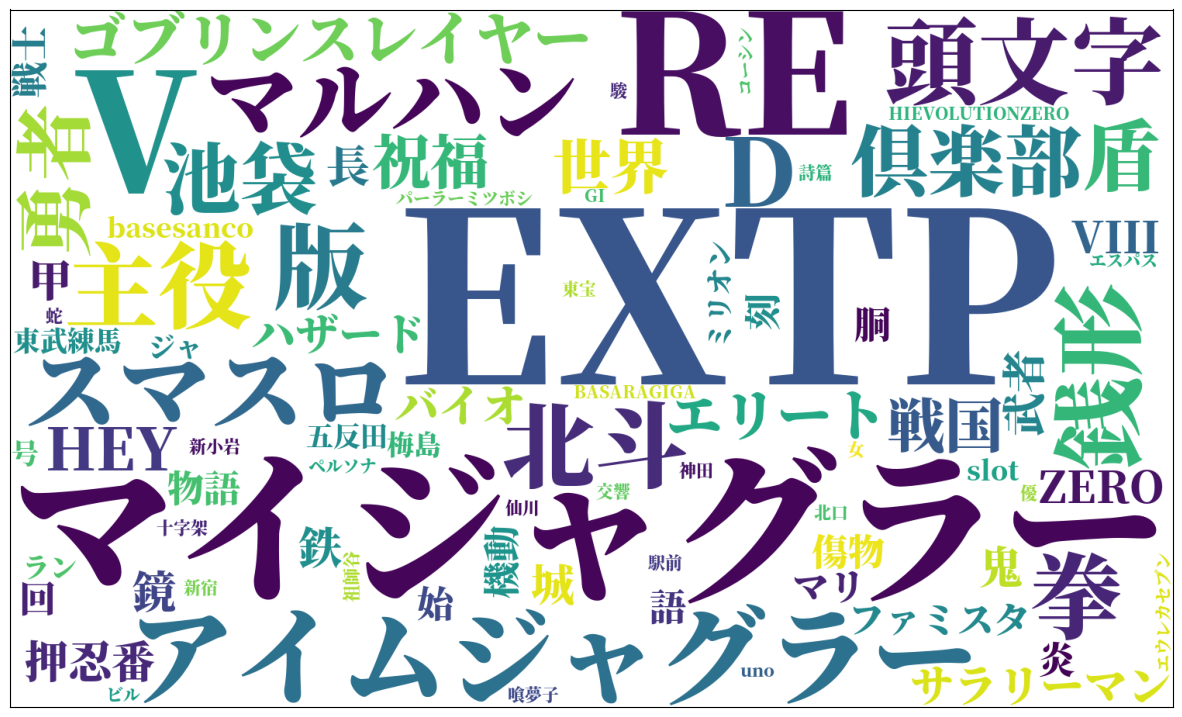

In [13]:
word_cloud_text_list = top_10_dif_coins_hall_name_list + word_cloud_machine_name_text_list


In [14]:



response = wordpress_upload_image(word_cloud_thumbnail_path)
media_id = int(response['id'])
print('media_id',media_id)

prefrecture_id = tag_df[tag_df['name'].str.contains(prefecture_name)]['id'].values[0]


title = f'{target_day_str_jp} {prefecture_name} {target_day_text}のパチンコスロットお勧め店舗TOP10'
print(title)
slug = prefecture_name_en + '-' + target_day_str
print(slug)

old_event_tag_id = int(target_day_text[0]) + 17
print(old_event_tag_id)
tag_list = [old_event_tag_id,prefrecture_id]
# 記事を下書き投稿する


{'id': 156, 'date': '2023-11-07T02:31:21', 'date_gmt': '2023-11-06T17:31:21', 'guid': {'rendered': 'http://pachislo7.com/wp-content/uploads/2023/11/tokyo_2023-11-13-1.jpg', 'raw': 'http://pachislo7.com/wp-content/uploads/2023/11/tokyo_2023-11-13-1.jpg'}, 'modified': '2023-11-07T02:31:21', 'modified_gmt': '2023-11-06T17:31:21', 'slug': 'tokyo_2023-11-13-1', 'status': 'inherit', 'type': 'attachment', 'link': 'https://pachislo7.com/tokyo_2023-11-13-1/', 'title': {'raw': 'tokyo_2023-11-13-1', 'rendered': 'tokyo_2023-11-13-1'}, 'author': 1, 'comment_status': 'open', 'ping_status': 'closed', 'template': '', 'meta': [], 'permalink_template': 'https://pachislo7.com/?attachment_id=156', 'generated_slug': 'tokyo_2023-11-13-1', 'description': {'raw': '', 'rendered': '<p class="attachment"><a href=\'https://pachislo7.com/wp-content/uploads/2023/11/tokyo_2023-11-13-1.jpg\'><img loading="lazy" width="300" height="200" src="https://pachislo7.com/wp-content/uploads/2023/11/tokyo_2023-11-13-1-300x200.j

NameError: name 'tag_df' is not defined

In [52]:
top_10_dif_coins_hall_name_list

['ジャラン五反田店',
 'ミリオン東武練馬13号店',
 'マルハン池袋-slot-base',
 'sanco梅島店',
 'パーラーミツボシ祖師谷店',
 'エスパス1300新小岩北口駅前店',
 'マルハン池袋店',
 '仙川uno',
 'マルハン新宿東宝ビル店',
 'コーシン神田店']

In [ ]:
serched_df[serched_df['店舗名'].str.contains('池袋')]['店舗名'].unique()

array(['pia池袋', 'toho池袋店', 'スマートプレゴ池袋', 'マルハン池袋-slot-base', 'マルハン池袋店',
       '楽園池袋店', 'ジャパンニューアルファ池袋店'], dtype=object)

In [ ]:
load_dotenv()
os.getenv('WORDPRESS_PACHISLO7_PW')

'6tjc5306'

In [ ]:
from urllib.parse import urljoin
def wp_tag_add(tagname:str) -> int:
        WP_URL: str = os.getenv('WORDPRESS_PACHISLO7_URL')
        WP_USER: str = os.getenv('WORDPRESS_PACHISLO7_ID')
        WP_API_PASSWORD: str = os.getenv('WORDPRESS_PACHISLO7_PW')
        API_URL = f"{WP_URL}/wp-json/wp/v2/"
        TAG_URL = urljoin(WP_URL, '/wp-json/wp/v2/tags/')
        post = {
            'name': tagname,
        }
        print(post)
        res = requests.post(
            TAG_URL ,
            json=post,
            auth=(WP_USER, WP_API_PASSWORD),
            )
        data = json.loads(res.text)
        print(data)
        if 'code' in data:
            if data['code'] == "term_exists":
                tag_id = data['data']['term_id']
                print(tag_id)
        else:
            tag_id = data['id']
            print(tag_id)
        return tag_id
    
location_df = pd.read_csv(r'csv\アナスロとホールナビの店舗名比較_マスター.csv')
location_df_a = location_df[location_df['url_店舗名'].isin(top_10_dif_coins_hall_name_list)]
location_df_a

location_map_html_df = pd.merge(location_df_a,halldata_df, left_on='hallnavi_name',right_on='hall_name', how='left')
tag_ids_text = ''
for hall_navi_name in location_map_html_df['hallnavi_name'].unique():
    #タグを登録する
    print(hall_navi_name)
    time.sleep(1)
    tag_id:int = wp_tag_add(hall_navi_name)
    tag_ids_text += str(tag_id) + ','

tag_ids_text = tag_ids_text[:-1]

res = post_article('draft', #ステータス 公開：publish, 下書き：draft
                   slug,
                   title,
                   write_html,
                   category_ids=[5],
                   tag_ids_text=tag_ids_text ,
                   media_id=media_id,
                   prefectue_id=prefrecture_id,
                   old_event_tag_id=old_event_tag_id
                   )

print(res,res.text) #レスポンスが201だったら成功、それ以外(401など)だったら失敗

In [59]:
prefecture_name_list = '''北海道
青森県


['東京都']

In [58]:
for i in range(3,13):
    today = datetime.date.today()
    target_day_number = i
    target_day = today + datetime.timedelta(days=target_day_number)
    today_str = today.strftime('%Y-%m-%d')
    target_day_str = target_day.strftime('%Y-%m-%d')
    #print(target_day_str,target_day_str)
    #曜日のリスト
    target_day_last_char = target_day_str[-1]
    target_day_text = str(target_day_last_char) + 'の付く日'
    print(target_day_text)

0の付く日
1の付く日
2の付く日
3の付く日
4の付く日
5の付く日
6の付く日
7の付く日
8の付く日
9の付く日


In [45]:

tag = 26
tag_id = wp_tag_add('東京都')


{'name': '東京都'}
{'code': 'term_exists', 'message': 'このタクソノミーにはすでに同じ名前とスラッグの項目があります。', 'data': {'status': 400, 'term_id': 84}, 'additional_data': [84, 84]}
84


In [51]:
SITE_URL = 'https://pachislo7.com/' 
API_URL = f"{SITE_URL}/wp-json/wp/v2/"
AUTH_USER = 'tsc953u'
AUTH_PASS = 'IyQe A1m6 YL4e f66u YjBn zzEo'

#下書き状態の記事を取得
#wordpress rest api でtagをand条件指定
print('tag',tag)
label = f'posts/?tags={tag},{tag_id}&status=draft&fields=id,slug,title,content,excerpt,featured_media'
#&status=draft&fields=id,slug,title,content,excerpt,featured_media'
url = f"{API_URL}{label}"
# すべてのアイテムを取得
print(url)
res = requests.get(url, auth=(AUTH_USER, AUTH_PASS)).json()
res


tag 26
https://pachislo7.com//wp-json/wp/v2/posts/?tags=26,84&status=draft&fields=id,slug,title,content,excerpt,featured_media


[{'id': 168,
  'date': '2023-11-07T02:59:42',
  'date_gmt': '2023-11-06T17:59:42',
  'guid': {'rendered': 'https://pachislo7.com/?p=168'},
  'modified': '2023-11-07T02:59:42',
  'modified_gmt': '2023-11-06T17:59:42',
  'slug': 'tokyo-2023-11-09',
  'status': 'draft',
  'type': 'post',
  'link': 'https://pachislo7.com/?p=168',
  'title': {'rendered': '11月9日(木) 東京都 9の付く日のパチンコスロットお勧め店舗TOP10'},
  'content': {'rendered': '<div class =\'container\'>\n<div class="row">\n<div class="col-12 pt-3">\n<h1>東京都【11月9日(木)】9の付く日のパチンコ・スロット・イベント・オススメ店舗</h1>\n<details class="qa-001">\n<summary>この記事はなんですか？</summary>\n<p>この記事は東京都 11月9日(木)のスロットを過去の統計データを使ったパチンコ店のお勧め記事です。</p>\n</details>\n<div class="toc-002">\n<div>\n                    目次</p>\n<p style="color :#edff00; margin-top: 0px;margin-bottom: 0px;"> (※クリックでジャンプ可能)</p>\n</div>\n<ol>\n<li><a href="#top10_recommend_tenpo_list_image">11月9日(木)お勧め店舗一覧表(画像)</a></li>\n<li><a href="#old_event_tenpo_list_image">9の付く日特定日店舗一覧表(画像)</a></li>\n<li>\n               

In [55]:
top_10_dif_coins_hall_name_list 
location_df = pd.read_csv(r'csv\アナスロとホールナビの店舗名比較_マスター.csv')
location_df_a = location_df[location_df['url_店舗名'].isin(top_10_dif_coins_hall_name_list)]
location_map_html_df = pd.merge(location_df_a,halldata_df, left_on='hallnavi_name',right_on='hall_name', how='left')
location_map_html_df 

,店舗名,URL,url_店舗名,都道府県,anaslo_name_x,hallnavi_name,prefecture,id,hall_name,prefecture_name,...,machine_move,dedama_share,car_parking,bicycle_parking,mobile_charging,dedama_info,access_info,longitude,latitude,anaslo_name_y
0,SANCO梅島店,https://ana-slo.com/%e3%83%9b%e3%83%bc%e3%83%a...,sanco梅島店,東京都,SANCO梅島店,サンコー梅島店,東京都,90,サンコー梅島店,東京都,...,不明,不明,不明,不明,可能,不明,無し,139.797653,35.773521,None
1,エスパス1300新小岩北口駅前店,https://ana-slo.com/%e3%83%9b%e3%83%bc%e3%83%a...,エスパス1300新小岩北口駅前店,東京都,エスパス1300新小岩北口駅前店,エスパス1300新小岩北口駅前店,東京都,112,エスパス1300新小岩北口駅前店,東京都,...,可能,可能,無し,有り,可能,不明,無し,139.857803,35.717495,None
2,コーシン神田店,https://ana-slo.com/%e3%83%9b%e3%83%bc%e3%83%a...,コーシン神田店,東京都,コーシン神田店,コーシン神田店,東京都,18,コーシン神田店,東京都,...,可能,可能,無し,無し,可能,不明,無し,139.770264,35.690895,None
3,ジャラン五反田店,https://ana-slo.com/%e3%83%9b%e3%83%bc%e3%83%a...,ジャラン五反田店,東京都,ジャラン五反田店,ジャラン五反田店,東京都,204,ジャラン五反田店,東京都,...,可能,不明,無し,無し,可能,サイトセブン,無し,139.722687,35.626320,None
4,パーラーミツボシ祖師谷店,https://ana-slo.com/%e3%83%9b%e3%83%bc%e3%83%a...,パーラーミツボシ祖師谷店,東京都,パーラーミツボシ祖師谷店,ミツボシ祖師谷店,東京都,275,ミツボシ祖師谷店,東京都,...,可能,可能,無し,有り,可能,不明,無し,139.608826,35.643578,None
5,マルハン新宿東宝ビル店,https://ana-slo.com/%e3%83%9b%e3%83%bc%e3%83%a...,マルハン新宿東宝ビル店,東京都,マルハン新宿東宝ビル店,マルハン新宿東宝ビル店,東京都,280,マルハン新宿東宝ビル店,東京都,...,可能,可能,無し,無し,可能,不明,無し,139.702133,35.694897,None
6,マルハン池袋 SLOT BASE,https://ana-slo.com/%e3%83%9b%e3%83%bc%e3%83%a...,マルハン池袋-slot-base,東京都,マルハン池袋 SLOT BASE,マルハン池袋 SLOT BASE,東京都,339,マルハン池袋 SLOT BASE,東京都,...,,,,,,,,139.713486,35.732723,None
7,マルハン池袋店,https://ana-slo.com/%e3%83%9b%e3%83%bc%e3%83%a...,マルハン池袋店,東京都,マルハン池袋店,マルハン池袋店,東京都,337,マルハン池袋店,東京都,...,可能,可能,無し,無し,可能,マルハン'sNET,無し,139.713577,35.732601,None
8,ミリオン東武練馬13号店,https://ana-slo.com/%e3%83%9b%e3%83%bc%e3%83%a...,ミリオン東武練馬13号店,東京都,ミリオン東武練馬13号店,ミリオン東武練馬13号店,東京都,402,ミリオン東武練馬13号店,東京都,...,可能,可能,無し,有り,可能,不明,無し,139.662186,35.767826,None
9,仙川UNO,https://ana-slo.com/%e3%83%9b%e3%83%bc%e3%83%a...,仙川uno,東京都,仙川UNO,仙川UNO,東京都,412,仙川UNO,東京都,...,可能,可能,提携駐車場有,有り,可能,不明,,139.583923,35.662617,None
